# <center> ETUDE de Marché </center>

# <center>  NB 1/2 - Préparation, Nettoyage et Analyse exploratoire des données </center>

### Sommaire

* [Introduction](#chapter1)
    * [Contexte](#section_1_1)
    * [Import Librairies](#section_1_2)
    * [Définition fonctions graphiques](#section_1_3)
    
* [Import et préparation des données](#chapter2)
    * [Import et calcul des variables choisies](#section_2_1)
    * [Fusion des dataframes](#section_2_2)
    * [Traitement des valeurs manquantes](#section_2_3)
    * [Exploration des valeurs du dataframe complet](#section_2_4)
    
* [Création du dataframe de travail](#chapter3)  
* [Analyse exploratoire des données - ACP](#chapter4)
    * [Eboulis des valeurs propres](#section_4_1)
    * [Les composantes](#section_4_2)
    * [Les cercles de corrélation](#section_4_3)
        

## Chapitre 1: Introduction <a class="anchor" id="chapter1"></a>

### 1.1 Contexte <a class="anchor" id="section_1_1"></a>

L'entreprise cherche à se développer  à l’international.
Ma mission est de cibler un groupe de pays pour exporter de poulets.
Dans un 2eme tmps, cela pourra être approfondi par une étude de marché.
J'ai sélectionné les données sur la base d’une étude PESTEL.
- Politique:
    - Stabilité politique
    - Evolution de la stabilité politique dps 5 ans
- Economique
    - Population
    - Croissance la population dps 5 ans
    - PIB par habitant
- Economique & socioculturel
    - Importation de volailles
    - Dispo protéines (en g/)
    - Dispo protéines animales
- Economique & ecologique
    - Distance de puis la FR


### 1.2 Import Librairies <a class="anchor" id="section_1_2"></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### 1.3 Définition fonctions graphiques <a class="anchor" id="section_1_3"></a>

In [2]:
#définition de la fonction pour tracer le Cercle de corrélation
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Le titre du graphe
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)


In [3]:
#définition de la fonction pour projeter les individus (et leurs clusters)
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette="deep")

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()


## Chapitre 2: Import et préparation des données <a class="anchor" id="chapter2"></a>

### 2.1 Import et calcul des variables choisies <a class="anchor" id="section_2_1"></a>

A partir du fichier fourni par Patrick, on va extraire et/ou calculer les variables sélectionnées.

In [4]:
#Import du fichier fourni par Patrick
Dispo_Alimentaire =pd.read_csv("DisponibiliteAlimentaire_2017.csv")

On va calculer la Dispo intérieure produits animaux en qté.

In [5]:
# création de la liste des protéines animales
proteines = ['Viande de Bovins',  "Viande d'Ovins/Caprins", 'Viande de Suides','Viande de Volailles', 'Viande, Autre', 
             'Abats Comestible','Poissons Eau Douce','Perciform', 'Poissons Pelagiques', 'Poissons Marins, Autres', 'Crustacés',
             'Cephalopodes', 'Mollusques, Autres', 'Animaux Aquatiques Autre','Viande de Anim Aquatiq']
#on conserve que les données liées aux protéines animales
Dispo_Alimentaire_proteines = Dispo_Alimentaire[Dispo_Alimentaire.Produit.isin(proteines)]
# puis les disponibilités intérieures
Dispo_interieure_proteines = Dispo_Alimentaire_proteines.loc[Dispo_Alimentaire_proteines['Élément']=='Disponibilité intérieure']

In [6]:
#aggrégation des données par pays (zone) dans un df qui indique la dispo intérieure des produits type protéines animales
#et calcule de la valeur totale
df_Dispo_interieure_proteines_pivot = Dispo_interieure_proteines.pivot_table(
                                        index = ['Code zone','Zone'], columns ='Produit', values ='Valeur', aggfunc='sum', margins = True)
df_Dispo_interieure_proteines_pivot = df_Dispo_interieure_proteines_pivot.reset_index()

#on ne conserve que le total
df_Dispo_interieure_proteines_pivot=df_Dispo_interieure_proteines_pivot[['Code zone','Zone', 'All']]
df_Dispo_interieure_proteines_pivot = df_Dispo_interieure_proteines_pivot.loc[df_Dispo_interieure_proteines_pivot['Code zone']!='All']
#on renomme la colonne
df_Dispo_interieure_proteines_pivot = df_Dispo_interieure_proteines_pivot.rename(columns={'All': 'Dispo int prot animales (Milliers de t)'})
df_Dispo_interieure_proteines_pivot.head()

Produit,Code zone,Zone,Dispo int prot animales (Milliers de t)
0,1,Arménie,185.0
1,2,Afghanistan,391.0
2,3,Albanie,168.0
3,4,Algérie,1000.0
4,7,Angola,1438.0


In [7]:
#Vérification des éventuelles anomalies
df_Dispo_interieure_proteines_pivot.describe(include='all')

Produit,Code zone,Zone,Dispo int prot animales (Milliers de t)
count,174.0,174,174.000000
unique,174.0,174,NaN
top,1.0,Arménie,NaN
freq,1.0,1,NaN
mean,NaN,NaN,2986.224138
std,NaN,NaN,13013.319750
min,NaN,NaN,4.000000
25%,NaN,NaN,156.750000
50%,NaN,NaN,514.000000
75%,NaN,NaN,1431.750000


==> Remarques: pas de valeurs manquantes, pas de doublon, les valeurs min et max semblent cohérentes.

On extrait les données sur les importations de volailles:

In [8]:
#on extrait les données 'importation' & 'viande de volailles'
Importation_volailles = Dispo_Alimentaire.loc[(Dispo_Alimentaire['Élément']=='Importations - Quantité') & (Dispo_Alimentaire['Produit']=='Viande de Volailles')]
#on ne conserve que les colonnes qui nous intéressent
Importation_volailles = Importation_volailles[['Code zone', 'Zone', 'Valeur']]
#on renomme la colonne
Importation_volailles = Importation_volailles.rename(columns={'Valeur': 'Importation volailles (Milliers de t)'})
Importation_volailles.head()

,Code zone,Zone,Importation volailles (Milliers de t)
652,2,Afghanistan,29.0
1705,202,Afrique du Sud,514.0
2714,3,Albanie,38.0
3773,4,Algérie,2.0
4874,79,Allemagne,842.0


In [9]:
# on vérifie les anomalies
Importation_volailles.describe(include='all')

,Code zone,Zone,Importation volailles (Milliers de t)
count,170.000000,170,170.000000
unique,NaN,170,NaN
top,NaN,Afghanistan,NaN
freq,NaN,1,NaN
mean,126.041176,NaN,89.529412
std,72.927812,NaN,186.669983
min,1.000000,NaN,0.000000
25%,66.250000,NaN,3.000000
50%,121.500000,NaN,16.000000
75%,187.250000,NaN,81.250000


==> Remarques: pas de valeurs manquantes, pas de doublons, les valeurs min et max semblent ok.

le df contient 170 lignes uniques alors que 174 sur le df des dispo interieure de protéines animales. ==> à garder en tête pour la suite.

On va extraire la disponibilité protéines.

In [10]:
#on extrait les données 'dispo de proteines en quantité'
Dispo_proteines = Dispo_Alimentaire.loc[Dispo_Alimentaire['Élément']=='Disponibilité de protéines en quantité (g/personne/jour)']
# somme des disponibilités par pays quelque soit le produit
Dispo_proteines_pivot = Dispo_proteines.groupby(['Code zone', 'Zone'])['Valeur'].sum()
Dispo_proteines_pivot = Dispo_proteines_pivot.reset_index()
# on renomme la colonne
Dispo_proteines_pivot = Dispo_proteines_pivot.rename(columns={'Valeur': 'Dispo protéines (en g/personne/jour)'})
Dispo_proteines_pivot.head()

,Code zone,Zone,Dispo protéines (en g/personne/jour)
0,1,Arménie,97.33
1,2,Afghanistan,54.09
2,3,Albanie,119.50
3,4,Algérie,92.85
4,7,Angola,54.09


In [11]:
# on vérifie les anomalies
Dispo_proteines_pivot.describe(include='all')

,Code zone,Zone,Dispo protéines (en g/personne/jour)
count,172.000000,172,172.000000
unique,NaN,172,NaN
top,NaN,Arménie,NaN
freq,NaN,1,NaN
mean,126.639535,NaN,81.192907
std,72.976310,NaN,20.199063
min,1.000000,NaN,39.910000
25%,66.750000,NaN,64.212500
50%,121.500000,NaN,81.390000
75%,188.250000,NaN,96.445000


==> Remarques: pas de valeurs manquantes, pas de doublons, les valeurs min et max semblent cohérentes

Nous avons 172 valeurs uniques.

On va importer les données pour la population et la croissance de population.

In [12]:
#Import des données
Pop_2000_2018 = pd.read_csv('Population_2000_2018.csv')
Pop_2000_2018.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN


In [13]:
#Mise en forme via une table pivot pour obtenir une ligne par pays et une valeur de population par colonne pour chaque année
Pop_2000_2018_pivot = Pop_2000_2018.pivot_table(
                        index = ['Code zone', 'Zone'], columns ='Année', values ='Valeur', aggfunc='sum')
Pop_2000_2018_pivot = Pop_2000_2018_pivot.reset_index()
#Calcul de la croissance de 2015 à 2018
Pop_2000_2018_pivot['croissance pop 2015-2018(en %)']=((Pop_2000_2018_pivot[2018]-Pop_2000_2018_pivot[2013])*100/Pop_2000_2018_pivot[2018]).round(2)
#on ne conserve que les valeurs qui nous intéressent
Pop_2000_2018_pivot = Pop_2000_2018_pivot[['Code zone', 'Zone', 2015, 2018, 'croissance pop 2015-2018(en %)']]
#on renomme la colonne
Pop_2000_2018_pivot = Pop_2000_2018_pivot.rename(columns={2018: 'Population 2018 (Milliers d\'hab)'})
Pop_2000_2018_pivot.head()

Année,Code zone,Zone,2015,Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %)
0,1,Arménie,2925.553,2951.745,1.83
1,2,Afghanistan,34413.603,37171.921,13.19
2,3,Albanie,2890.513,2882.740,-0.73
3,4,Algérie,39728.025,42228.408,9.68
4,5,Samoa américaines,55.812,55.465,-0.45


In [14]:
# vérification des anomalies
Pop_2000_2018_pivot.describe(include='all').round(2)

Année,Code zone,Zone,2015,Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %)
count,238.00,238,236.00,236.00,236.00
unique,NaN,238,NaN,NaN,NaN
top,NaN,Arménie,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN
mean,135.41,NaN,31271.47,32336.31,5.62
std,77.92,NaN,129789.38,132916.30,5.73
min,1.00,NaN,0.80,0.80,-15.54
25%,69.25,NaN,377.41,385.00,1.85
50%,134.50,NaN,5027.97,5291.16,5.08
75%,198.75,NaN,18564.26,19567.45,9.78


==> Remarques: il y 2 valeurs manquantes pour la population et la croissance, pas de doublons, les valeurs min et max semblent cohérentes.

il y a 238 valeurs pour 174 et 170 dans les précédents df. ==> à analyser lors de la fusion.

On va importer les données politique et calculer l'évolution.

In [15]:
#Import des données
Stabilite_Politique = pd.read_csv('StabilitePolitique_2000_2020.csv')
Stabilite_Politique.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,2,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2000,2000,indice,-2.44,X,Ciffre de sources internationales,NaN
1,FS,Données de la sécurité alimentaire,2,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2002,2002,indice,-2.04,X,Ciffre de sources internationales,NaN
2,FS,Données de la sécurité alimentaire,2,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2003,2003,indice,-2.20,X,Ciffre de sources internationales,NaN
3,FS,Données de la sécurité alimentaire,2,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2004,2004,indice,-2.30,X,Ciffre de sources internationales,NaN
4,FS,Données de la sécurité alimentaire,2,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2005,2005,indice,-2.07,X,Ciffre de sources internationales,NaN


In [16]:
#Mise en forme par un pivot pour avoir une ligne par pays, une colonne par année avec la valeur de la stabilité politique
Stabilite_Politique_pivot=Stabilite_Politique.pivot_table(
                            index = ['Code zone','Zone'], columns = 'Année', values = 'Valeur')
Stabilite_Politique_pivot = Stabilite_Politique_pivot.reset_index()
#Calcul de l'évolution de la stabilité politique de 2015 à 2020
Stabilite_Politique_pivot['Evol stab pol 2015-2020']=(Stabilite_Politique_pivot[2020]-Stabilite_Politique_pivot[2015]).round(2)
#on ne conserve que les colonne qui nous intéressent
Stabilite_Politique_pivot = Stabilite_Politique_pivot[['Code zone', 'Zone', 2020, 'Evol stab pol 2015-2020']]
#on renomme la colonne
Stabilite_Politique_pivot = Stabilite_Politique_pivot.rename(columns={2020: 'Stab pol 2020'})
Stabilite_Politique_pivot.head()

Année,Code zone,Zone,Stab pol 2020,Evol stab pol 2015-2020
0,1,Arménie,-0.57,-0.32
1,2,Afghanistan,-2.73,-0.16
2,3,Albanie,0.08,-0.27
3,4,Algérie,-0.86,0.23
4,5,Samoa américaines,1.17,-0.01


In [17]:
# vérification des anomalies
Stabilite_Politique_pivot.describe(include='all')

Année,Code zone,Zone,Stab pol 2020,Evol stab pol 2015-2020
count,199.000000,199,199.000000,197.000000
unique,NaN,199,NaN,NaN
top,NaN,Arménie,NaN,NaN
freq,NaN,1,NaN,NaN
mean,128.326633,NaN,-0.058945,-0.012538
std,75.451361,NaN,0.994801,0.296799
min,1.000000,NaN,-2.730000,-0.960000
25%,62.000000,NaN,-0.645000,-0.150000
50%,127.000000,NaN,0.020000,-0.010000
75%,192.000000,NaN,0.780000,0.150000


==> Remarques: 2 valeurs manquantes pour l'évolution de la stabilité, pas de doublon, les valeurs min et max sont cohérentes.

le df compte 199 lignes.

Pour calculer la distance depuis la FR, nous allons utiliser 2 fichiers:
- un pour les distances et 
- le second pour la concordance code ISO et nom du pays.



In [18]:
# import des données distance
distances = pd.read_excel("dist_cepii.xlsx")
distances.head()

,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap,distw,distwces
0,ABW,ABW,0,0,0,0,0,0,0,0,5.225315,5.225315,25.09354,23.04723
1,ABW,AFG,0,0,0,0,0,0,0,0,13257.810000,13257.810000,13168.22,13166.37
2,ABW,AGO,0,0,0,0,0,0,0,0,9516.913000,9516.913000,9587.316,9584.193
3,ABW,AIA,0,0,1,0,0,0,0,0,983.268200,983.268200,976.8974,976.8916
4,ABW,ALB,0,0,0,0,0,0,0,0,9091.742000,9091.742000,9091.576,9091.466


In [19]:
# on ne va garder que les distances dps la France (FRA)
distances_France = distances.loc[distances['iso_o']=='FRA']
distances_France = distances_France.reset_index()
# on ne conserve que les colonnes qui nous intéressent
distances_France = distances_France[['iso_o', 'iso_d', 'dist']]
distances_France.head()

,iso_o,iso_d,dist
0,FRA,ABW,7685.884
1,FRA,AFG,5590.381
2,FRA,AGO,6510.322
3,FRA,AIA,6710.570
4,FRA,ALB,1603.534


In [20]:
#import des données géographiques
iso_geo=pd.read_excel("geo_cepii.xlsx")
iso_geo.head()

,iso2,iso3,cnum,country,pays,area,dis_int,landlocked,continent,city_en,...,lang9_2,lang9_3,lang9_4,colonizer1,colonizer2,colonizer3,colonizer4,short_colonizer1,short_colonizer2,short_colonizer3
0,AW,ABW,533,Aruba,Aruba,193,5.225315,0,America,Oranjestad,...,.,.,.,NLD,.,.,.,.,.,.
1,AF,AFG,4,Afghanistan,Afghanistan,652225,303.761400,1,Asia,Kabul,...,Uzbek,.,.,.,.,.,.,GBR,.,.
2,AO,AGO,24,Angola,Angola,1246700,419.966600,0,Africa,Luanda,...,.,.,.,PRT,.,.,.,.,.,.
3,AI,AIA,660,Anguilla,Anguilla,102,3.798690,0,America,The Valley,...,.,.,.,GBR,.,.,.,.,.,.
4,AL,ALB,8,Albania,Albanie,28748,63.773110,0,Europe,Tirana,...,.,.,.,TUR,.,.,.,.,.,.


In [21]:
# on ne conserve que les colonnes qui nous interessent
iso_geo = iso_geo[['iso3','pays']]

In [22]:
# fusion des 2 df par une fusion à gauche (données sur les distance), attention les 2 clés primaires sont nommées différemment
distance_France_merge=distances_France.merge(iso_geo, how='left', left_on='iso_d', right_on='iso3')
#Vérification des anomalies
distance_France_merge.describe(include='all')

,iso_o,iso_d,dist,iso3,pays
count,237,237,237.000000,237,237
unique,1,224,NaN,224,224
top,FRA,KAZ,NaN,KAZ,Kazakstan
freq,237,2,NaN,2,2
mean,NaN,NaN,6674.357603,NaN,NaN
std,NaN,NaN,4247.546495,NaN,NaN
min,NaN,NaN,262.384500,NaN,NaN
25%,NaN,NaN,3584.681000,NaN,NaN
50%,NaN,NaN,6491.402000,NaN,NaN
75%,NaN,NaN,8981.467000,NaN,NaN


==> Remarques: 
- pas de valeurs manquantes, 
- il y a des doublons. à analyser!
- les valeurs min et max sont cohérentes.

le df comporte 237 valeurs dont 224 uniques.

In [23]:
# on ne conserve que les colonnes qui nous intéressent
distance_France_merge = distance_France_merge[['pays','dist', 'iso3']]
#on renomme la colonne pour éviter toute confusion
distance_France_merge = distance_France_merge.rename(columns={'dist': 'distance dps France(en km)'})

In [24]:
distance_France_merge.value_counts().head(20)

pays                           distance dps France(en km)  iso3
Brésil                         9408.4060                   BRA     2
Australie                      16975.4600                  AUS     2
Côte d'Ivoire                  4884.1590                   CIV     2
Tanzanie                       7168.2770                   TZA     2
Canada                         6004.6450                   CAN     2
Bénin                          4726.5370                   BEN     2
Bolivie                        10038.4500                  BOL     2
Turquie                        2255.8100                   TUR     2
Nigéria                        4722.1490                   NGA     2
Kazakstan                      5561.7850                   KAZ     2
Etats-Unis d'Amérique          5838.1570                   USA     2
Allemagne                      439.8984                    DEU     2
Afrique du Sud                 9353.5520                   ZAF     2
Micronésie (Etats fédérés de)  13396.33

In [25]:
# Suppression des doublons
distance_France_merge = distance_France_merge.drop_duplicates(subset='pays', keep='first')

On va avoir besoin de données de groupe pour qualifier les pays afin de calculer les valeurs manquantes de façon la plus précise (ou moins mauvaise) possible.

In [26]:
#Import des données 
groupe_pays=pd.read_csv('pays et groupes.csv')
groupe_pays.head()

,Code Groupe de pays,Groupe de pays,Code Pays,Pays,Code M49,Code ISO2,Code ISO3
0,5100,Afrique,616,"Afrique de l'Ouest, non spécifié",875.0,F616,F616
1,5100,Afrique,202,Afrique du Sud,710.0,ZA,ZAF
2,5100,Afrique,4,Algérie,12.0,DZ,DZA
3,5100,Afrique,7,Angola,24.0,AO,AGO
4,5100,Afrique,24,Archipel des Chagos,86.0,IO,IOT


In [27]:
#Exploration des données
groupe_pays.groupby(['Code Groupe de pays', 'Groupe de pays'])['Pays'].count()

Code Groupe de pays  Groupe de pays                                                     
336                  Amérique Nord et Centrale                                               14
420                  Afrique subsaharienne                                                   54
429                  Afrique du Nord (Soudan Excl)                                            6
5000                 Monde                                                                  280
5100                 Afrique                                                                 63
5101                 Afrique orientale                                                       23
5102                 Afrique centrale                                                         9
5103                 Afrique septentrionale                                                   8
5104                 Afrique australe                                                         5
5105                 Afrique occidentale       

==> Remarques: les continents portent les numéros: 5100,5200, 5300, 5400,5500.

On va créer un df spécifique avec les pays et leur continent respectif.


In [28]:
#création d'une liste avec les codes des continents
code_continent = [5100,5200, 5300, 5400,5500]
# on ne conserve que les lignes pays avec leur continent respectif
pays_continents = groupe_pays.loc[groupe_pays['Code Groupe de pays'].isin(code_continent)]
#on vérifie que le pays n'est présent qu'une fois
pays_continents['Pays'].value_counts()

Chine, continentale                 2
Chine                               2
Afrique de l'Ouest, non spécifié    1
Allemagne Nl                        1
Bosnie-Herzégovine                  1
                                   ..
Île Bouvet                          1
Îles Caïmanes                       1
Îles Falkland (Malvinas)            1
Îles Turques-et-Caïques             1
Vanuatu                             1
Name: Pays, Length: 277, dtype: int64

In [29]:
pays_continents.loc[(pays_continents['Pays']=='Chine, continentale')|(pays_continents['Pays']=='Chine')]

,Code Groupe de pays,Groupe de pays,Code Pays,Pays,Code M49,Code ISO2,Code ISO3
446,5300,Asie,351,Chine,159.0,F351,CHN
447,5300,Asie,351,Chine,159.0,F351,F351
450,5300,Asie,41,"Chine, continentale",156.0,CN,CHN
451,5300,Asie,41,"Chine, continentale",156.0,CN,F41


On va vérifier quel pays est présent dans les données de dispo alimentaires. le df 'Importation_volailles' est celui qui comporte le moins de variables, il sera le plus contraignant.

In [30]:
Importation_volailles.loc[(Importation_volailles['Zone']=='Chine, continentale')|(Importation_volailles['Zone']=='Chine')]

,Code zone,Zone,Importation volailles (Milliers de t)
35873,41,"Chine, continentale",452.0


==> on va donc conserver la ligne 450.

In [31]:
#suppression des lignes
pays_continents = pays_continents.drop(index=[446, 447,451])
#verification
pays_continents.describe(include='all')

,Code Groupe de pays,Groupe de pays,Code Pays,Pays,Code M49,Code ISO2,Code ISO3
count,276.000000,276,276.000000,276,276.000000,275,276
unique,NaN,5,NaN,276,NaN,274,275
top,NaN,Europe,NaN,"Afrique de l'Ouest, non spécifié",NaN,F275,F275
freq,NaN,64,NaN,1,NaN,2,2
mean,5280.797101,NaN,153.916667,NaN,438.735688,NaN,NaN
std,135.756796,NaN,116.325704,NaN,257.563889,NaN,NaN
min,5100.000000,NaN,1.000000,NaN,4.000000,NaN,NaN
25%,5200.000000,NaN,71.750000,NaN,221.000000,NaN,NaN
50%,5300.000000,NaN,141.500000,NaN,432.000000,NaN,NaN
75%,5400.000000,NaN,212.250000,NaN,660.500000,NaN,NaN


In [32]:
#quel est le pays en doublon?
pays_continents.loc[pays_continents['Code ISO3']=='F275']

,Code Groupe de pays,Groupe de pays,Code Pays,Pays,Code M49,Code ISO2,Code ISO3
704,5400,Europe,275,Kosovo,412.0,F275,F275
705,5400,Europe,275,Kosovo (Serbia),412.0,F275,F275


In [33]:
#est-il dans les données de la disponibilité alimentaire?
Importation_volailles.loc[Importation_volailles['Code zone']== 275]

,Code zone,Zone,Importation volailles (Milliers de t)


Non il n'y est pas... on va juste supprimer le doublon.

In [34]:
#suppression doublon
pays_continents = pays_continents.drop_duplicates(subset='Code ISO3', keep='first')
pays_continents.describe(include='all')

,Code Groupe de pays,Groupe de pays,Code Pays,Pays,Code M49,Code ISO2,Code ISO3
count,275.000000,275,275.000000,275,275.000000,274,275
unique,NaN,5,NaN,275,NaN,274,275
top,NaN,Afrique,NaN,"Afrique de l'Ouest, non spécifié",NaN,F616,F616
freq,NaN,63,NaN,1,NaN,1,1
mean,5280.363636,NaN,153.476364,NaN,438.832909,NaN,NaN
std,135.812823,NaN,116.307147,NaN,258.028394,NaN,NaN
min,5100.000000,NaN,1.000000,NaN,4.000000,NaN,NaN
25%,5200.000000,NaN,71.500000,NaN,220.000000,NaN,NaN
50%,5300.000000,NaN,141.000000,NaN,434.000000,NaN,NaN
75%,5400.000000,NaN,211.500000,NaN,661.000000,NaN,NaN


==> Remarques: le df est ok!

In [35]:
#renomme les colonnes et mise en forme
pays_continents = pays_continents.rename(columns={'Groupe de pays': 'Continent'})
pays_continents = pays_continents[['Continent', 'Code Pays', 'Pays', 'Code ISO3']]
pays_continents.head()

,Continent,Code Pays,Pays,Code ISO3
0,Afrique,616,"Afrique de l'Ouest, non spécifié",F616
1,Afrique,202,Afrique du Sud,ZAF
2,Afrique,4,Algérie,DZA
3,Afrique,7,Angola,AGO
4,Afrique,24,Archipel des Chagos,IOT


On  va maintenant extraire l'information du sous-groupe.

In [36]:
#création de la liste
code_sous_continent = [5101,5102,5103,5104,5105,
                       5203,5204,5206,5207,
                       5301,5302,5303,5303,5304,5305,
                       5401,5402,5403,5404,
                       5501,5502,5503,5504]
pays_sous_continent= groupe_pays.loc[groupe_pays['Code Groupe de pays'].isin(code_sous_continent)]
#on renomme la colonne pour éviter confusion
pays_sous_continent = pays_sous_continent.rename(columns={'Groupe de pays': 'Sous Continent'})
# on conserve que les colonnes qui nous intéressent
pays_sous_continent = pays_sous_continent[['Sous Continent', 'Code Pays', 'Pays', 'Code ISO3']]
pays_sous_continent.describe(include='all')

,Sous Continent,Code Pays,Pays,Code ISO3
count,275,275.000000,275,275
unique,22,NaN,273,273
top,Caraïbes,NaN,Chine,CHN
freq,30,NaN,2,2
mean,NaN,155.705455,NaN,NaN
std,NaN,117.718877,NaN,NaN
min,NaN,1.000000,NaN,NaN
25%,NaN,70.500000,NaN,NaN
50%,NaN,144.000000,NaN,NaN
75%,NaN,214.500000,NaN,NaN


==> Remarques:
- il y a au moins un doublon.

In [37]:
#verification sur les pays
pays_sous_continent['Pays'].value_counts()

Chine                              2
Chine, continentale                2
Afrique du Sud                     1
Saint-Martin (partie française)    1
Bosnie-Herzégovine                 1
                                  ..
Tadjikistan                        1
Turkménistan                       1
Brunéi Darussalam                  1
Cambodge                           1
Tuvalu                             1
Name: Pays, Length: 273, dtype: int64

In [38]:
#verification sur les code ISO
pays_sous_continent['Code ISO3'].value_counts()

CHN     2
F275    2
ZAF     1
MAF     1
AND     1
       ..
TJK     1
TKM     1
BRN     1
KHM     1
TUV     1
Name: Code ISO3, Length: 273, dtype: int64

In [39]:
pays_sous_continent.loc[(pays_sous_continent['Pays']=='Chine')|(pays_sous_continent['Pays']=='Chine, continentale')|
                        (pays_sous_continent['Code ISO3']=='CHN')|(pays_sous_continent['Code ISO3']=='F275')]

,Sous Continent,Code Pays,Pays,Code ISO3
584,Asie orientale,351,Chine,CHN
585,Asie orientale,351,Chine,F351
588,Asie orientale,41,"Chine, continentale",CHN
589,Asie orientale,41,"Chine, continentale",F41
742,Europe méridionale,275,Kosovo,F275
743,Europe méridionale,275,Kosovo (Serbia),F275


==> Remarques: comme pour le précédent df, on ne garde que le 1er Kosovo et l'index 588.

In [40]:
#suppression des lignes
pays_sous_continent = pays_sous_continent.drop(index=[584, 585, 589, 743])
#vérification
pays_sous_continent.describe(include='all')

,Sous Continent,Code Pays,Pays,Code ISO3
count,271,271.000000,271,271
unique,22,NaN,271,271
top,Caraïbes,NaN,Afrique du Sud,ZAF
freq,30,NaN,1,1
mean,NaN,154.247232,NaN,NaN
std,NaN,116.948460,NaN,NaN
min,NaN,1.000000,NaN,NaN
25%,NaN,70.500000,NaN,NaN
50%,NaN,143.000000,NaN,NaN
75%,NaN,212.500000,NaN,NaN


==> Remarques: le df est ok!

On va avoir besoin des données de PIB de chaque pays pour calculer le PIB par habitant.

In [41]:
#import des données
df_PIB=pd.read_excel('PIB_DataBank.xls')

In [42]:
#exploration
df_PIB.describe().round(2)

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,1.180000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.300000e+02,1.330000e+02,1.340000e+02,1.370000e+02,1.370000e+02,...,2.550000e+02,2.550000e+02,2.580000e+02,2.540000e+02,2.540000e+02,2.540000e+02,2.520000e+02,2.490000e+02,2.440000e+02,0.0
mean,5.676190e+11,5.639489e+11,5.926603e+11,6.225910e+11,6.645218e+11,6.673140e+11,6.891843e+11,7.108281e+11,7.395720e+11,7.852589e+11,...,2.272919e+12,2.350770e+12,2.400531e+12,2.514604e+12,2.608735e+12,2.702279e+12,2.801759e+12,2.756255e+12,2.982760e+12,NaN
std,1.753688e+12,1.788514e+12,1.886948e+12,1.985003e+12,2.113220e+12,2.174573e+12,2.278364e+12,2.365258e+12,2.479413e+12,2.614517e+12,...,7.717007e+12,7.953667e+12,8.157715e+12,8.449322e+12,8.742703e+12,9.037193e+12,9.314428e+12,9.090747e+12,9.724605e+12,NaN
min,1.347232e+08,1.281457e+08,1.389209e+08,1.530014e+08,1.620579e+08,1.603392e+08,1.693168e+08,1.531914e+08,1.631637e+08,1.678316e+08,...,3.333886e+07,3.333886e+07,3.681166e+07,3.889534e+07,3.958990e+07,4.028446e+07,4.584093e+07,4.653549e+07,4.792461e+07,NaN
25%,3.664653e+09,3.600436e+09,3.693484e+09,3.969274e+09,4.237786e+09,4.471586e+09,4.534049e+09,4.451183e+09,5.111455e+09,5.301663e+09,...,8.296302e+09,8.602695e+09,8.589120e+09,9.473463e+09,9.807325e+09,1.019091e+10,1.042669e+10,1.034253e+10,1.091205e+10,NaN
50%,2.714765e+10,2.748194e+10,2.855243e+10,3.103232e+10,3.182588e+10,2.829509e+10,2.578914e+10,2.717058e+10,2.936521e+10,3.128882e+10,...,5.109467e+10,5.115884e+10,4.966795e+10,5.173008e+10,5.456212e+10,5.668094e+10,6.009007e+10,6.104614e+10,6.574623e+10,NaN
75%,1.890752e+11,1.996738e+11,2.070493e+11,2.156791e+11,2.283119e+11,2.250487e+11,2.200861e+11,2.302863e+11,2.473244e+11,2.693963e+11,...,5.323731e+11,5.311700e+11,5.020845e+11,5.656730e+11,5.812936e+11,5.741273e+11,5.984091e+11,6.510272e+11,7.818332e+11,NaN
max,1.090308e+13,1.131631e+13,1.191789e+13,1.253588e+13,1.335801e+13,1.409927e+13,1.490471e+13,1.552364e+13,1.644610e+13,1.740242e+13,...,7.075475e+13,7.294153e+13,7.518636e+13,7.729554e+13,7.991295e+13,8.253958e+13,8.467853e+13,8.204101e+13,8.686028e+13,NaN


Nettoyage du df_PIB sur une version de travail df_PIB_W:
- suppression Indicator Name et Indicator Code
- suppression des années 1960 à 2010 & 2019 à 2022 (on a la population 2018)

In [43]:
#création d'une copie
df_PIB_W= df_PIB.copy()
#on conserve les colonnes intéressantes
df_PIB_W = df_PIB_W[['Country Name', 'Country Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']]
#Mettre les valeurs en millions
df_PIB_W[['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']] = df_PIB_W[['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']]/1000000
#on arrondit avec 2 décimales
df_PIB_W=df_PIB_W.round(2)

In [44]:
df_PIB_W.describe(include='all').round(2)

,Country Name,Country Code,2010,2011,2012,2013,2014,2015,2016,2017,2018
count,264,266,253.00,254.00,253.00,255.00,255.00,258.00,254.00,254.00,254.00
unique,264,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2073315.99,2144212.91,2219410.79,2272919.19,2350769.90,2400531.09,2514603.93,2608734.64,2702279.45
std,NaN,NaN,7118085.23,7332038.47,7538056.53,7717007.13,7953666.59,8157715.12,8449322.12,8742703.27,9037193.26
min,NaN,NaN,30.56,32.64,31.95,33.34,33.34,36.81,38.90,39.59,40.28
25%,NaN,NaN,7543.95,7624.05,8259.61,8296.30,8602.70,8589.12,9473.46,9807.32,10190.91
50%,NaN,NaN,45669.36,47360.25,49133.79,51094.67,51158.84,49667.96,51730.08,54562.12,56680.94
75%,NaN,NaN,509171.78,537083.18,579910.25,532373.11,531170.02,502084.53,565673.02,581293.56,574127.29


==> Remarques:
- l'année 2015 est l'année la plus complète.

On va conserver que cette colonne.

In [45]:
df_PIB_W = df_PIB_W[['Country Name','Country Code','2015']]
df_PIB_W.rename(columns={'2015': 'PIB'}, inplace=True)
df_PIB_W.head(5)

,Country Name,Country Code,PIB
0,Aruba,ABW,2963.13
1,NaN,AFE,923143.90
2,Afghanistan,AFG,19998.16
3,NaN,AFW,766957.96
4,Angola,AGO,87219.30


### 2.2 Fusion des dataframes  <a class="anchor" id="section_2_2"></a>

**Toutes nos données sont disponibles dans des df séparés, nous allons maintenant effectuer des fusions pour obtenir un df unique avec toutes les données**

In [46]:
#fusion des données sur les protéines (animales ou non)
df_proteines = pd.merge(df_Dispo_interieure_proteines_pivot, Dispo_proteines_pivot,
                                                        how='outer', on=['Code zone', 'Zone'], indicator = True)
df_proteines._merge.value_counts() #pour savoir de quel df provient la ligne

both          172
left_only       2
right_only      0
Name: _merge, dtype: int64

In [47]:
#pour afficher les lignes qui seront donc avec des valeurs manquantes
df_proteines.loc[df_proteines['_merge']=='left_only']

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),_merge
12,17,Bermudes,4.0,NaN,left_only
18,26,Brunéi Darussalam,28.0,NaN,left_only


In [48]:
df_proteines = df_proteines.drop(columns='_merge') #suppression de la colonne créée lors de la fusion
df_proteines.describe(include='all') #exploration du df fusionné

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour)
count,174.0,174,174.000000,172.000000
unique,174.0,174,NaN,NaN
top,1.0,Arménie,NaN,NaN
freq,1.0,1,NaN,NaN
mean,NaN,NaN,2986.224138,81.192907
std,NaN,NaN,13013.319750,20.199063
min,NaN,NaN,4.000000,39.910000
25%,NaN,NaN,156.750000,64.212500
50%,NaN,NaN,514.000000,81.390000
75%,NaN,NaN,1431.750000,96.445000


==> pas de remarques.

In [49]:
#fusion des df protéines et importation volailles
df_dispo = pd.merge(df_proteines, Importation_volailles,
                   how='outer', on=['Code zone', 'Zone'], indicator = True)
df_dispo._merge.value_counts() #pour savoir de quel df provient la ligne

both          170
left_only       4
right_only      0
Name: _merge, dtype: int64

In [50]:
df_dispo.loc[df_dispo['_merge']=='left_only']#pour afficher les lignes qui seront donc avec des valeurs manquantes

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),_merge
12,17,Bermudes,4.0,NaN,NaN,left_only
18,26,Brunéi Darussalam,28.0,NaN,NaN,left_only
86,120,République démocratique populaire lao,176.0,83.19,NaN,left_only
162,235,Ouzbékistan,75.0,93.52,NaN,left_only


In [51]:
#suppression de la colonne et exploration
df_dispo = df_dispo.drop(columns='_merge')
df_dispo.describe(include='all')

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t)
count,174.0,174,174.000000,172.000000,170.000000
unique,174.0,174,NaN,NaN,NaN
top,1.0,Arménie,NaN,NaN,NaN
freq,1.0,1,NaN,NaN,NaN
mean,NaN,NaN,2986.224138,81.192907,89.529412
std,NaN,NaN,13013.319750,20.199063,186.669983
min,NaN,NaN,4.000000,39.910000,0.000000
25%,NaN,NaN,156.750000,64.212500,3.000000
50%,NaN,NaN,514.000000,81.390000,16.000000
75%,NaN,NaN,1431.750000,96.445000,81.250000


==> pas de remarques.

In [52]:
#fusion des données alimentaires aux données population
df_dispo_pop = pd.merge(df_dispo,Pop_2000_2018_pivot,
                       how='left', on=['Code zone', 'Zone'])
#exploration
df_dispo_pop.describe(include='all').round(2)

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),2015,Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %)
count,174.0,174,174.00,172.00,170.00,174.00,174.00,174.00
unique,174.0,174,NaN,NaN,NaN,NaN,NaN,NaN
top,1.0,Arménie,NaN,NaN,NaN,NaN,NaN,NaN
freq,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2986.22,81.19,89.53,41427.06,42807.75,6.03
std,NaN,NaN,13013.32,20.20,186.67,149837.45,153411.35,5.37
min,NaN,NaN,4.00,39.91,0.00,51.20,52.44,-7.41
25%,NaN,NaN,156.75,64.21,3.00,2458.81,2536.54,2.37
50%,NaN,NaN,514.00,81.39,16.00,9353.00,9669.23,5.54
75%,NaN,NaN,1431.75,96.44,81.25,29532.47,30549.12,10.10


==> pas de remarques.

In [53]:
#fusion des données alimentaires & population aux données politique
df_dispo_pop_stab = pd.merge(df_dispo_pop, Stabilite_Politique_pivot,
                            how='left', on = ['Code zone', 'Zone'])
#exploration
df_dispo_pop_stab.describe(include='all').round(2)

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),2015,Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020
count,174.0,174,174.00,172.00,170.00,174.00,174.00,174.00,170.00,170.00
unique,174.0,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1.0,Arménie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2986.22,81.19,89.53,41427.06,42807.75,6.03,-0.07,-0.02
std,NaN,NaN,13013.32,20.20,186.67,149837.45,153411.35,5.37,0.91,0.30
min,NaN,NaN,4.00,39.91,0.00,51.20,52.44,-7.41,-2.73,-0.96
25%,NaN,NaN,156.75,64.21,3.00,2458.81,2536.54,2.37,-0.63,-0.16
50%,NaN,NaN,514.00,81.39,16.00,9353.00,9669.23,5.54,-0.02,-0.02
75%,NaN,NaN,1431.75,96.44,81.25,29532.47,30549.12,10.10,0.68,0.14


==> Remarques: 4 valeurs manquantes sur les données politique

In [54]:
#Quels sont les pays avec des valeurs manquantes?
df_dispo_pop_stab.loc[df_dispo_pop_stab['Stab pol 2020'].isna()]

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),2015,Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020
28,41,"Chine, continentale",160479.0,101.44,452.0,1406847.870,1427647.786,2.51,NaN,NaN
47,70,Polynésie française,44.0,97.51,15.0,273.124,277.679,2.65,NaN,NaN
107,150,Pays-Bas,1870.0,104.43,608.0,16938.499,17059.560,1.27,NaN,NaN
108,153,Nouvelle-Calédonie,37.0,83.12,9.0,271.065,279.993,5.63,NaN,NaN


==> Remarques: pour le pays de moins de 500 000 hb, on pourrait les supprimer. Pour les autres, on remplacera par Zéro (valeur neutre) les 2 variables. cf plus loin.

In [55]:
#fusion des données alimentaires-population-politique aux données distance
df_dispo_pop_stab_distance=pd.merge(df_dispo_pop_stab,distance_France_merge,
                   how='left', left_on ='Zone', right_on ='pays')
df_dispo_pop_stab_distance.describe(include='all' ).round(2)

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),2015,Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,pays,distance dps France(en km),iso3
count,174.0,174,174.00,172.00,170.00,174.00,174.00,174.00,170.00,170.00,140,140.00,140
unique,174.0,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,NaN,140
top,1.0,Arménie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arménie,NaN,ARM
freq,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
mean,NaN,NaN,2986.22,81.19,89.53,41427.06,42807.75,6.03,-0.07,-0.02,NaN,6099.34,NaN
std,NaN,NaN,13013.32,20.20,186.67,149837.45,153411.35,5.37,0.91,0.30,NaN,4055.14,NaN
min,NaN,NaN,4.00,39.91,0.00,51.20,52.44,-7.41,-2.73,-0.96,NaN,278.19,NaN
25%,NaN,NaN,156.75,64.21,3.00,2458.81,2536.54,2.37,-0.63,-0.16,NaN,3136.41,NaN
50%,NaN,NaN,514.00,81.39,16.00,9353.00,9669.23,5.54,-0.02,-0.02,NaN,5592.92,NaN
75%,NaN,NaN,1431.75,96.44,81.25,29532.47,30549.12,10.10,0.68,0.14,NaN,8666.11,NaN


==> Remarques: il y a bcp de valeurs manquantes sur la distance. D'où la nécessité de les remplacer.

On va effectuer la fusion avec les groupes et sous-groupes de pays pour effectuer le remplacement des valeurs manquantes par des projections de valeurs par sous-groupe.


In [56]:
# fusion des df groupes et sous-groupes
pays = pd.merge(pays_sous_continent, pays_continents, how='left', on=['Code Pays', 'Pays','Code ISO3'], indicator=True)
pays._merge.value_counts() #pour savoir de quel df provient la ligne

both          271
left_only       0
right_only      0
Name: _merge, dtype: int64

In [57]:
#suppression de la colonne et exploration
pays = pays.drop(columns='_merge')
pays.describe(include='all')

,Sous Continent,Code Pays,Pays,Code ISO3,Continent
count,271,271.000000,271,271,271
unique,22,NaN,271,271,5
top,Caraïbes,NaN,Afrique du Sud,ZAF,Afrique
freq,30,NaN,1,1,63
mean,NaN,154.247232,NaN,NaN,NaN
std,NaN,116.948460,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN
25%,NaN,70.500000,NaN,NaN,NaN
50%,NaN,143.000000,NaN,NaN,NaN
75%,NaN,212.500000,NaN,NaN,NaN


==> Pas de remarque.

In [58]:
# fusion du df dispo-population-politique-distance et du df pays
df_dispo_pop_stab_distance_continent=pd.merge(df_dispo_pop_stab_distance, pays,
                                             how='left', left_on='Code zone', right_on='Code Pays')
df_dispo_pop_stab_distance_continent.describe(include='all').round(2)

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),2015,Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,pays,distance dps France(en km),iso3,Sous Continent,Code Pays,Pays,Code ISO3,Continent
count,174.0,174,174.00,172.00,170.00,174.00,174.00,174.00,170.00,170.00,140,140.00,140,174,174.00,174,174,174
unique,174.0,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,NaN,140,22,NaN,174,174,5
top,1.0,Arménie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arménie,NaN,ARM,Afrique occidentale,NaN,Arménie,ARM,Asie
freq,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,16,NaN,1,1,45
mean,NaN,NaN,2986.22,81.19,89.53,41427.06,42807.75,6.03,-0.07,-0.02,NaN,6099.34,NaN,NaN,125.43,NaN,NaN,NaN
std,NaN,NaN,13013.32,20.20,186.67,149837.45,153411.35,5.37,0.91,0.30,NaN,4055.14,NaN,NaN,73.42,NaN,NaN,NaN
min,NaN,NaN,4.00,39.91,0.00,51.20,52.44,-7.41,-2.73,-0.96,NaN,278.19,NaN,NaN,1.00,NaN,NaN,NaN
25%,NaN,NaN,156.75,64.21,3.00,2458.81,2536.54,2.37,-0.63,-0.16,NaN,3136.41,NaN,NaN,63.75,NaN,NaN,NaN
50%,NaN,NaN,514.00,81.39,16.00,9353.00,9669.23,5.54,-0.02,-0.02,NaN,5592.92,NaN,NaN,120.50,NaN,NaN,NaN
75%,NaN,NaN,1431.75,96.44,81.25,29532.47,30549.12,10.10,0.68,0.14,NaN,8666.11,NaN,NaN,187.25,NaN,NaN,NaN


==> Remarques: 
- suppression des colonnes inutiles: pays, iso3, Code Pays, Pays
- valeurs manquantes sur la distance à remplacer par la moyenne du sous-groupe
- idem pour pour la dispo protéines (en g/pers/jour) et pour importation de volailles
- valeurs manquantes pour la stabilité pol et évolution stabilité par zéro.

In [59]:
#suppression des colonnes
df_dispo_pop_stab_distance_continent = df_dispo_pop_stab_distance_continent.drop(columns=['pays', 'iso3', 'Code Pays', 'Pays'])
df_dispo_pop_stab_distance_continent.head(2) #pour vérifier

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),2015,Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,distance dps France(en km),Sous Continent,Code ISO3,Continent
0,1,Arménie,185.0,97.33,35.0,2925.553,2951.745,1.83,-0.57,-0.32,3434.071,Asie occidentale,ARM,Asie
1,2,Afghanistan,391.0,54.09,29.0,34413.603,37171.921,13.19,-2.73,-0.16,5590.381,Asie méridionale,AFG,Asie


In [60]:
#Fusion avec les données PIB
df_dispo_pop_stab_distance_continent_PIB=pd.merge(df_dispo_pop_stab_distance_continent,df_PIB_W, 
                                                  how='left', left_on='Code ISO3', right_on='Country Code' )

On souhaite la variable PIB par habitant. Nous devons donc le calculer:

In [61]:
df_dispo_pop_stab_distance_continent_PIB['PIB_hb']=df_dispo_pop_stab_distance_continent_PIB['PIB']/df_dispo_pop_stab_distance_continent_PIB[2015].round(2)

In [62]:
#Quels sont les pays avec des valeurs manquantes?
df_dispo_pop_stab_distance_continent_PIB.loc[df_dispo_pop_stab_distance_continent_PIB['PIB_hb'].isna()]

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),2015,Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,distance dps France(en km),Sous Continent,Code ISO3,Continent,Country Name,Country Code,PIB,PIB_hb
82,116,République populaire démocratique de Corée,666.0,52.27,0.0,25183.833,25549.604,2.43,-0.40,0.75,NaN,Asie orientale,PRK,Asie,"Corée, République démocratique de",PRK,NaN,NaN
147,214,"Chine, Taiwan Province de",3271.0,85.71,161.0,23557.477,23726.460,1.28,0.77,-0.15,NaN,Asie orientale,TWN,Asie,NaN,NaN,NaN,NaN
163,236,Venezuela (République bolivarienne du),1656.0,56.30,25.0,30081.829,28887.118,-3.09,-1.52,-0.54,NaN,Amérique du Sud,VEN,Amériques,Venezuela,VEN,NaN,NaN


**==> Remarques:** les valeurs manquantes concernent:
- la république populaire démocratique de Corée: pas de libre échange, on supprime car pas une cible
- Taiwan: bcp de valeurs manquantes, on supprime
- Venezuela: pays en énorme crise économique depuis 5 ans; on supprime car pas une cible

### 2.3 Traitement des valeurs manquantes  <a class="anchor" id="section_2_3"></a>

In [63]:
#suppression des lignes
df_dispo_pop_stab_distance_continent_PIB.drop([82,147,163], axis=0, inplace=True)
#vérification
df_dispo_pop_stab_distance_continent_PIB.loc[df_dispo_pop_stab_distance_continent_PIB['PIB_hb'].isna()]

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),2015,Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,distance dps France(en km),Sous Continent,Code ISO3,Continent,Country Name,Country Code,PIB,PIB_hb


On peut maintenant supprimer les colonnes 2015 et PIB.

In [64]:
df_dispo_pop_stab_distance_continent_PIB.drop([2015,'PIB'], axis = 1, inplace=True)
df_dispo_pop_stab_distance_continent_PIB.describe(include='all').round(2)

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,distance dps France(en km),Sous Continent,Code ISO3,Continent,Country Name,Country Code,PIB_hb
count,171.0,171,171.00,169.00,167.00,171.00,171.00,167.00,167.00,140.00,171,171,171,171,171,171.00
unique,171.0,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,171,5,171,171,NaN
top,1.0,Arménie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afrique occidentale,ARM,Afrique,Arménie,ARM,NaN
freq,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,1,45,1,1,NaN
mean,NaN,NaN,3005.91,81.48,90.02,43101.67,6.13,-0.06,-0.02,6099.34,NaN,NaN,NaN,NaN,NaN,13.86
std,NaN,NaN,13126.01,20.16,188.07,154742.52,5.35,0.90,0.30,4055.14,NaN,NaN,NaN,NaN,NaN,19.43
min,NaN,NaN,4.00,39.91,0.00,52.44,-7.41,-2.73,-0.96,278.19,NaN,NaN,NaN,NaN,NaN,0.38
25%,NaN,NaN,148.00,64.45,3.00,2364.20,2.41,-0.62,-0.16,3136.41,NaN,NaN,NaN,NaN,NaN,2.00
50%,NaN,NaN,511.00,81.63,16.00,9587.52,5.67,-0.02,-0.02,5592.92,NaN,NaN,NaN,NaN,NaN,5.84
75%,NaN,NaN,1402.00,96.97,80.50,31168.91,10.20,0.68,0.13,8666.11,NaN,NaN,NaN,NaN,NaN,16.85


On va créer un df avec les moyennes de la distance, importation de volailles, et dispo protéines.

In [65]:
# 1/ création d'un df avec moyenne de la distance par sous-continent
df_moyenne = df_dispo_pop_stab_distance_continent.groupby('Sous Continent')['distance dps France(en km)','Importation volailles (Milliers de t)','Dispo protéines (en g/personne/jour)'].mean().reset_index()
# renomme les colonnes pour éviter confusion:
df_moyenne.rename(columns={'distance dps France(en km)': 'distance_moy'}, inplace=True)
df_moyenne.rename(columns={'Importation volailles (Milliers de t)': 'Imp_vol_moy'}, inplace=True)
df_moyenne.rename(columns={'Dispo protéines (en g/personne/jour)': 'Dispo_prot_moy'}, inplace=True)
df_moyenne.head()

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_14004\1510548841.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_moyenne = df_dispo_pop_stab_distance_continent.groupby('Sous Continent')['distance dps France(en km)','Importation volailles (Milliers de t)','Dispo protéines (en g/personne/jour)'].mean().reset_index()


,Sous Continent,distance_moy,Imp_vol_moy,Dispo_prot_moy
0,Afrique australe,8753.856500,112.600000,67.124000
1,Afrique centrale,5459.527000,66.285714,61.061429
2,Afrique occidentale,4475.865933,28.500000,63.561250
3,Afrique orientale,7471.611400,4.166667,60.415000
4,Afrique septentrionale,2313.364500,23.400000,90.800000


In [66]:
# 2/ jointure avec le df complet et création du df_temp
df_temp= pd.merge(df_dispo_pop_stab_distance_continent_PIB, df_moyenne, how='left', on='Sous Continent')
df_temp.describe(include='all').round(2)

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,distance dps France(en km),Sous Continent,Code ISO3,Continent,Country Name,Country Code,PIB_hb,distance_moy,Imp_vol_moy,Dispo_prot_moy
count,171.0,171,171.00,169.00,167.00,171.00,171.00,167.00,167.00,140.00,171,171,171,171,171,171.00,171.00,171.00,171.00
unique,171.0,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,171,5,171,171,NaN,NaN,NaN,NaN
top,1.0,Arménie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afrique occidentale,ARM,Afrique,Arménie,ARM,NaN,NaN,NaN,NaN
freq,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,1,45,1,1,NaN,NaN,NaN,NaN
mean,NaN,NaN,3005.91,81.48,90.02,43101.67,6.13,-0.06,-0.02,6099.34,NaN,NaN,NaN,NaN,NaN,13.86,6031.74,86.98,81.19
std,NaN,NaN,13126.01,20.16,188.07,154742.52,5.35,0.90,0.30,4055.14,NaN,NaN,NaN,NaN,NaN,19.43,3869.76,89.54,15.60
min,NaN,NaN,4.00,39.91,0.00,52.44,-7.41,-2.73,-0.96,278.19,NaN,NaN,NaN,NaN,NaN,0.38,484.39,1.00,60.42
25%,NaN,NaN,148.00,64.45,3.00,2364.20,2.41,-0.62,-0.16,3136.41,NaN,NaN,NaN,NaN,NaN,2.00,2313.36,28.50,68.59
50%,NaN,NaN,511.00,81.63,16.00,9587.52,5.67,-0.02,-0.02,5592.92,NaN,NaN,NaN,NaN,NaN,5.84,5459.53,52.00,77.26
75%,NaN,NaN,1402.00,96.97,80.50,31168.91,10.20,0.68,0.13,8666.11,NaN,NaN,NaN,NaN,NaN,16.85,8571.69,122.30,90.80


In [67]:
# 3/  remplacement valeurs manquantes par la moyenne du sous-continent
#et valeur de importation par moyenne
df_temp.loc[df_temp['distance dps France(en km)'].isna(), 'distance dps France(en km)']=df_temp['distance_moy']
df_temp.loc[df_temp['Importation volailles (Milliers de t)'].isna(), 'Importation volailles (Milliers de t)']=df_temp['Imp_vol_moy']
df_temp.loc[df_temp['Dispo protéines (en g/personne/jour)'].isna(), 'Dispo protéines (en g/personne/jour)']=df_temp['Dispo_prot_moy']
#remplacement par zéro des valeurs manquantes stabilité politique et evolution politique
df_temp[['Stab pol 2020','Evol stab pol 2015-2020']] = df_temp[['Stab pol 2020','Evol stab pol 2015-2020']].fillna(0)
df_temp.describe().round(2)

,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,distance dps France(en km),PIB_hb,distance_moy,Imp_vol_moy,Dispo_prot_moy
count,171.00,171.00,171.00,171.00,171.00,171.00,171.00,171.00,171.00,171.00,171.00,171.00
mean,3005.91,81.59,90.10,43101.67,6.13,-0.06,-0.02,6031.74,13.86,6031.74,86.98,81.19
std,13126.01,20.15,185.92,154742.52,5.35,0.89,0.29,3935.06,19.43,3869.76,89.54,15.60
min,4.00,39.91,0.00,52.44,-7.41,-2.73,-0.96,278.19,0.38,484.39,1.00,60.42
25%,148.00,64.77,3.00,2364.20,2.41,-0.61,-0.15,2284.59,2.00,2313.36,28.50,68.59
50%,511.00,81.63,16.00,9587.52,5.67,0.00,-0.01,5620.00,5.84,5459.53,52.00,77.26
75%,1402.00,97.12,80.69,31168.91,10.20,0.66,0.12,8595.23,16.85,8571.69,122.30,90.80
max,160479.00,141.34,1069.00,1427647.79,22.05,1.49,0.80,19263.88,105.99,18119.67,352.29,112.83


### 2.4 Exploration des valeurs du dataframe complet  <a class="anchor" id="section_2_4"></a>

On souhaite observer la distribution des valeurs. On va visualiser par des boxplots.

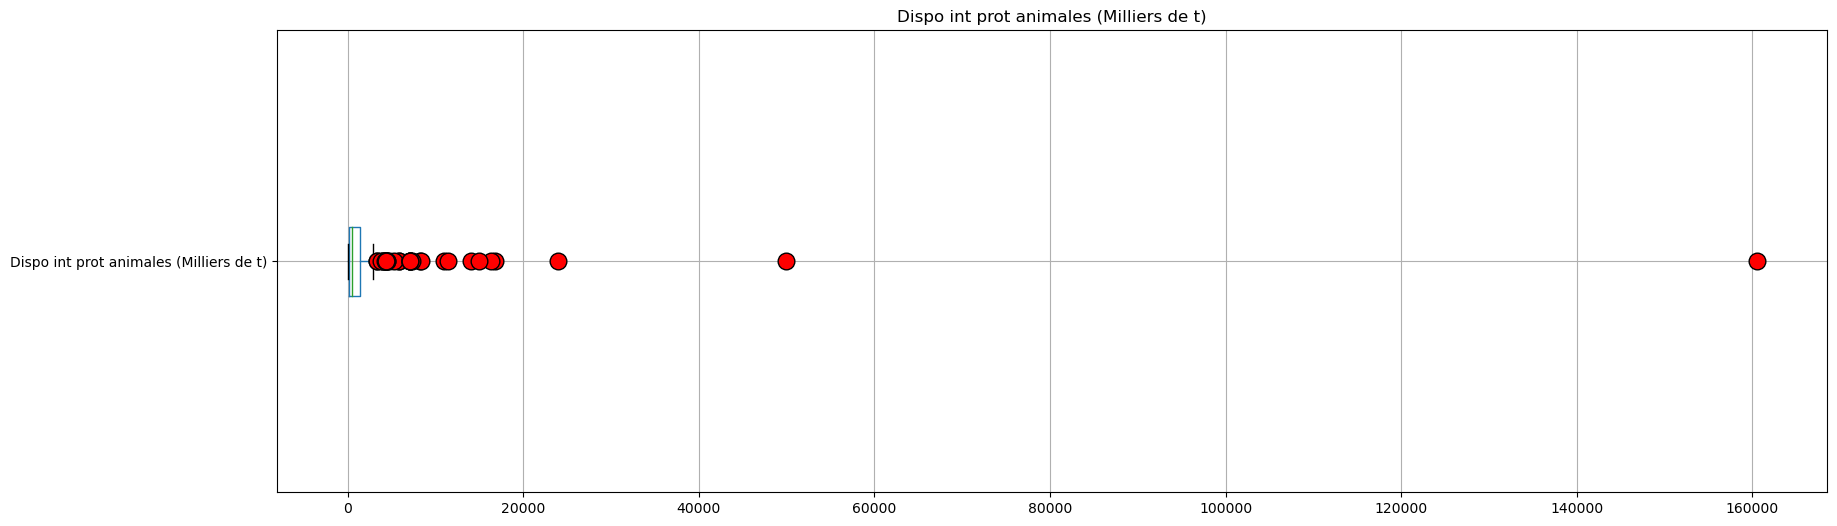

In [68]:
plt.figure(figsize=(20,6))
#définit le style des outliers (flier pour matplotlib)
flierprops = dict(marker='o', markerfacecolor='red', markersize=12,
                  linestyle='none')
df_temp.boxplot(column = 'Dispo int prot animales (Milliers de t)', vert = False, flierprops=flierprops)
plt.title('Dispo int prot animales (Milliers de t)')
plt.show()

==> Remarques: la plage de valeur est très large. Nous devrons créer une valeur normalisée pour réduire la distribution.

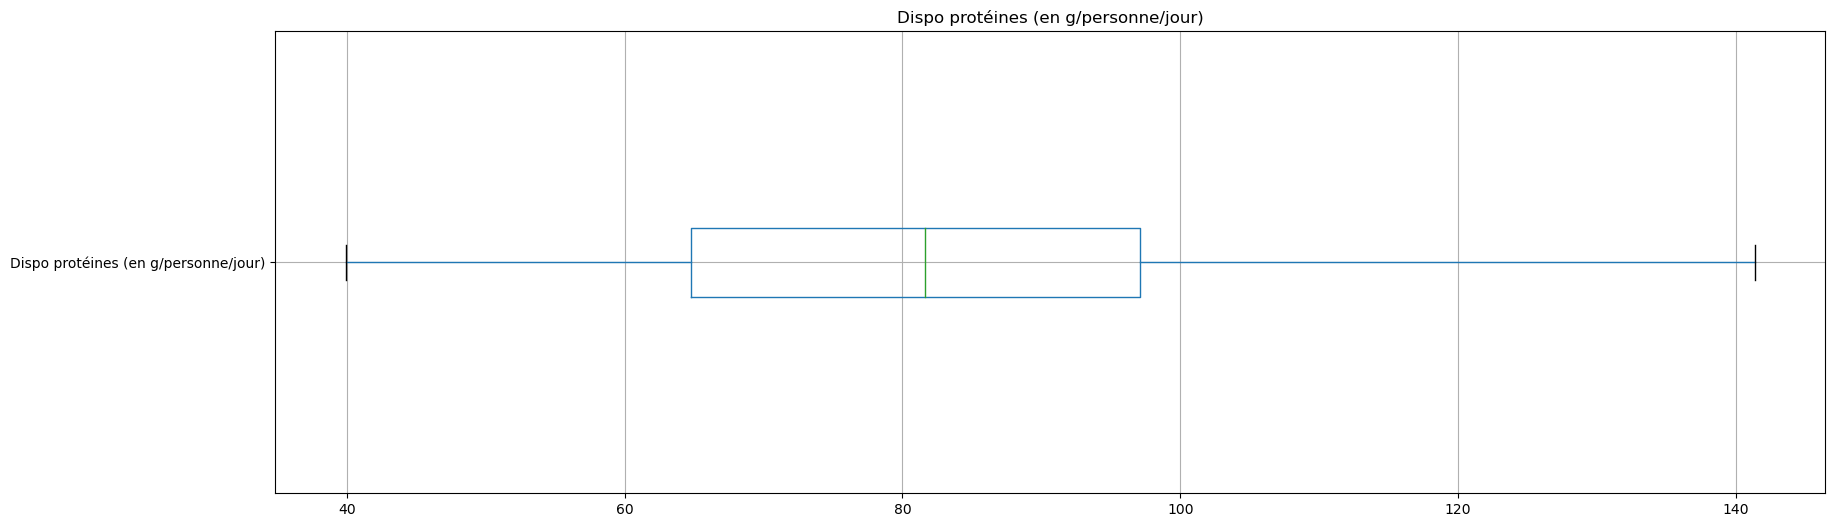

In [69]:
plt.figure(figsize=(20,6))
#définit le style des outliers (flier pour matplotlib)
flierprops = dict(marker='o', markerfacecolor='red', markersize=12,
                  linestyle='none')
df_temp.boxplot(column = 'Dispo protéines (en g/personne/jour)', vert = False, flierprops=flierprops)
plt.title('Dispo protéines (en g/personne/jour)')
plt.show()

==> Pas de remarques

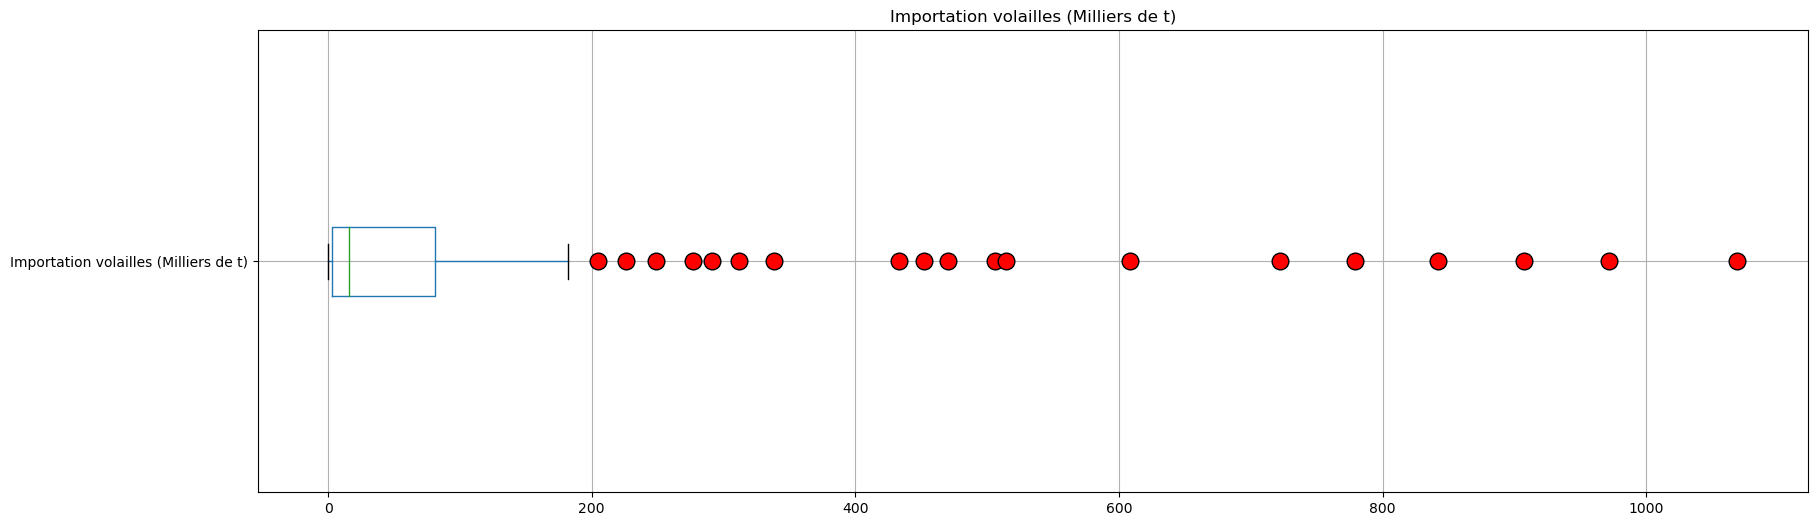

In [70]:
plt.figure(figsize=(20,6))
#définit le style des outliers (flier pour matplotlib)
flierprops = dict(marker='o', markerfacecolor='red', markersize=12,
                  linestyle='none')
df_temp.boxplot(column = 'Importation volailles (Milliers de t)', vert = False, flierprops=flierprops)
plt.title('Importation volailles (Milliers de t)')
plt.show()

==> Remarques: plage des outliers très large. Nous devrons créer une valeur normalisée pour réduire la distribution.

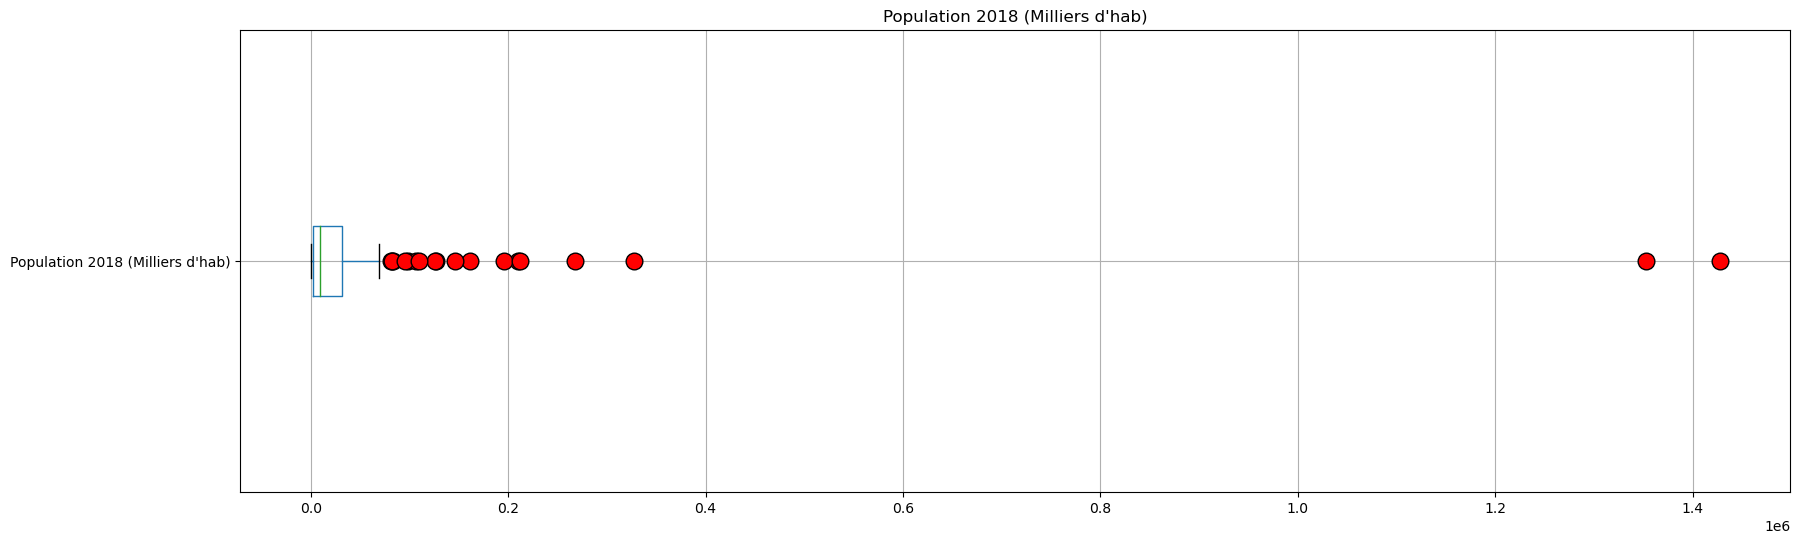

In [71]:
plt.figure(figsize=(20,6))
#définit le style des outliers (flier pour matplotlib)
flierprops = dict(marker='o', markerfacecolor='red', markersize=12,
                  linestyle='none')
df_temp.boxplot(column = 'Population 2018 (Milliers d\'hab)', vert = False, flierprops=flierprops)
plt.title('Population 2018 (Milliers d\'hab)')
plt.show()

==> Remarques: la plage des outliers est très large. Nous devrons créer une valeur normalisée pour réduire la distribution.

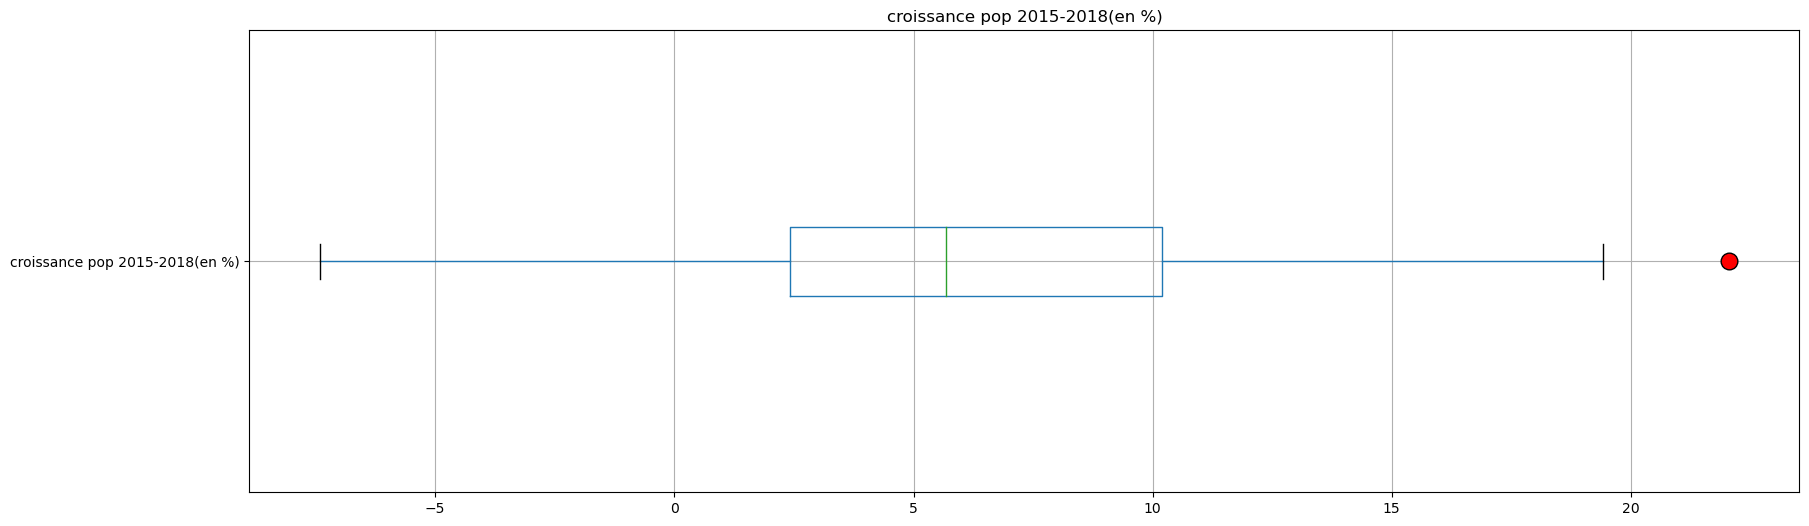

In [72]:
plt.figure(figsize=(20,6))
#définit le style des outliers (flier pour matplotlib)
flierprops = dict(marker='o', markerfacecolor='red', markersize=12,
                  linestyle='none')
df_temp.boxplot(column = 'croissance pop 2015-2018(en %)', vert = False, flierprops=flierprops)
plt.title('croissance pop 2015-2018(en %)')
plt.show()

==> pas de remarques

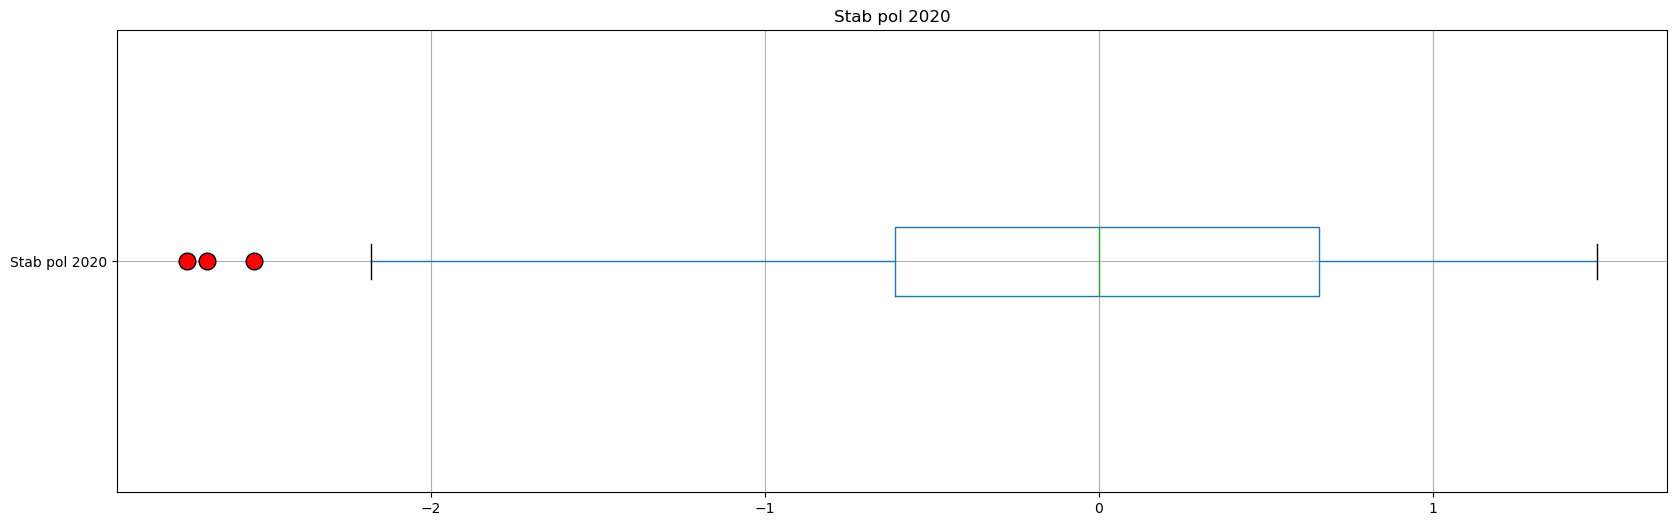

In [73]:
plt.figure(figsize=(20,6))
#définit le style des outliers (flier pour matplotlib)
flierprops = dict(marker='o', markerfacecolor='red', markersize=12,
                  linestyle='none')
df_temp.boxplot(column = 'Stab pol 2020', vert = False, flierprops=flierprops)
plt.title('Stab pol 2020')
plt.show()

==> pas de remarques

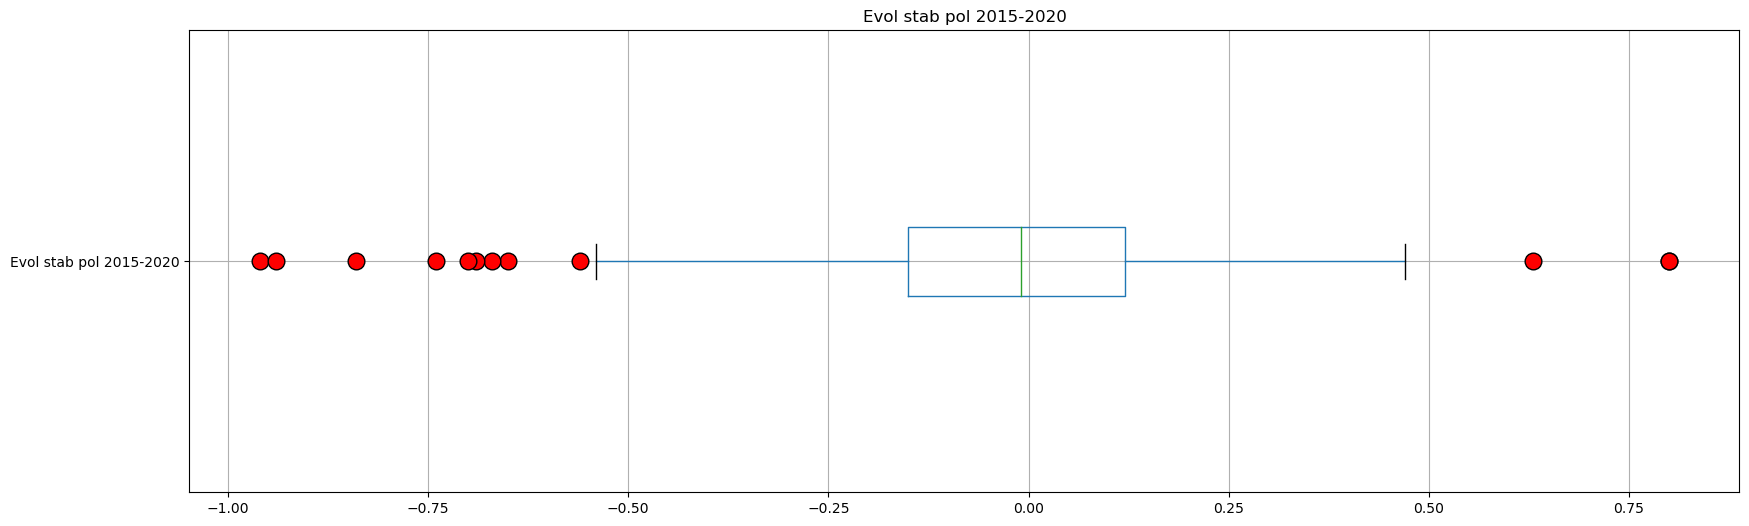

In [74]:
plt.figure(figsize=(20,6))
#définit le style des outliers (flier pour matplotlib)
flierprops = dict(marker='o', markerfacecolor='red', markersize=12,
                  linestyle='none')
df_temp.boxplot(column = 'Evol stab pol 2015-2020', vert = False, flierprops=flierprops)
plt.title('Evol stab pol 2015-2020')
plt.show()

==> pas de remarques

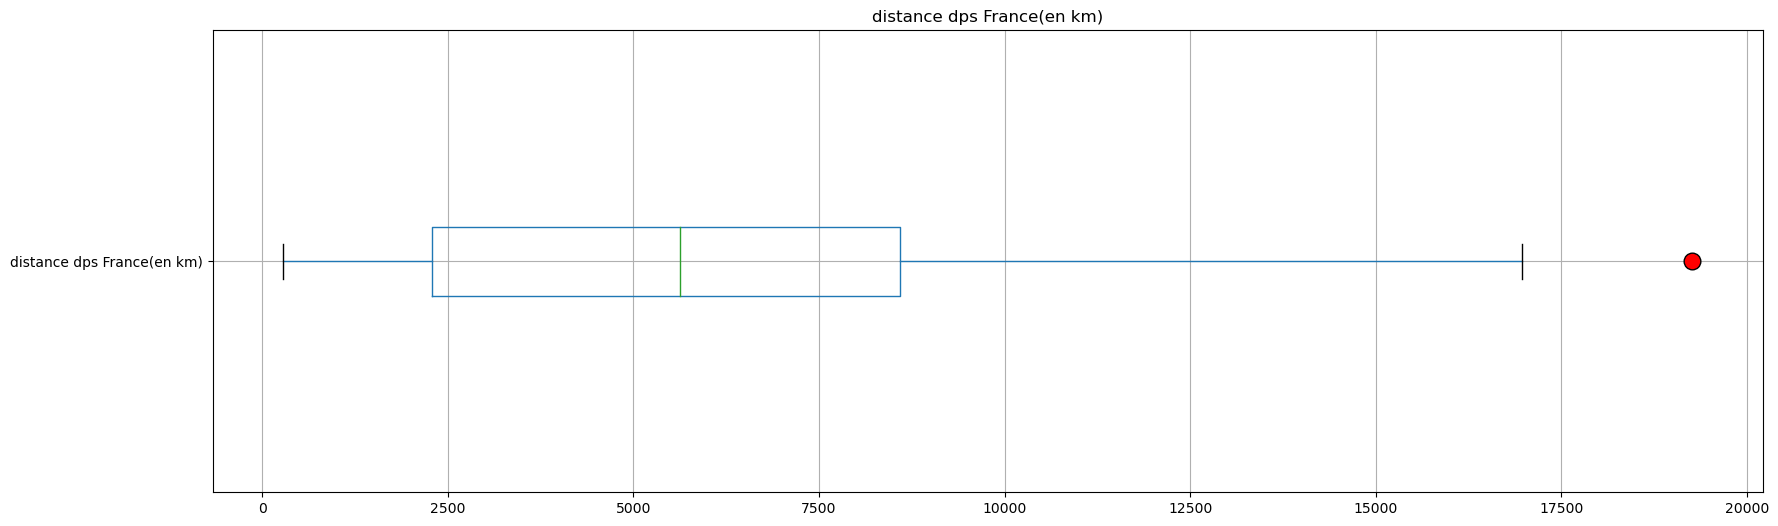

In [75]:
plt.figure(figsize=(20,6))
#définit le style des outliers (flier pour matplotlib)
flierprops = dict(marker='o', markerfacecolor='red', markersize=12,
                  linestyle='none')
df_temp.boxplot(column = 'distance dps France(en km)', vert = False, flierprops=flierprops)
plt.title('distance dps France(en km)')
plt.show()

==> pas de remarques

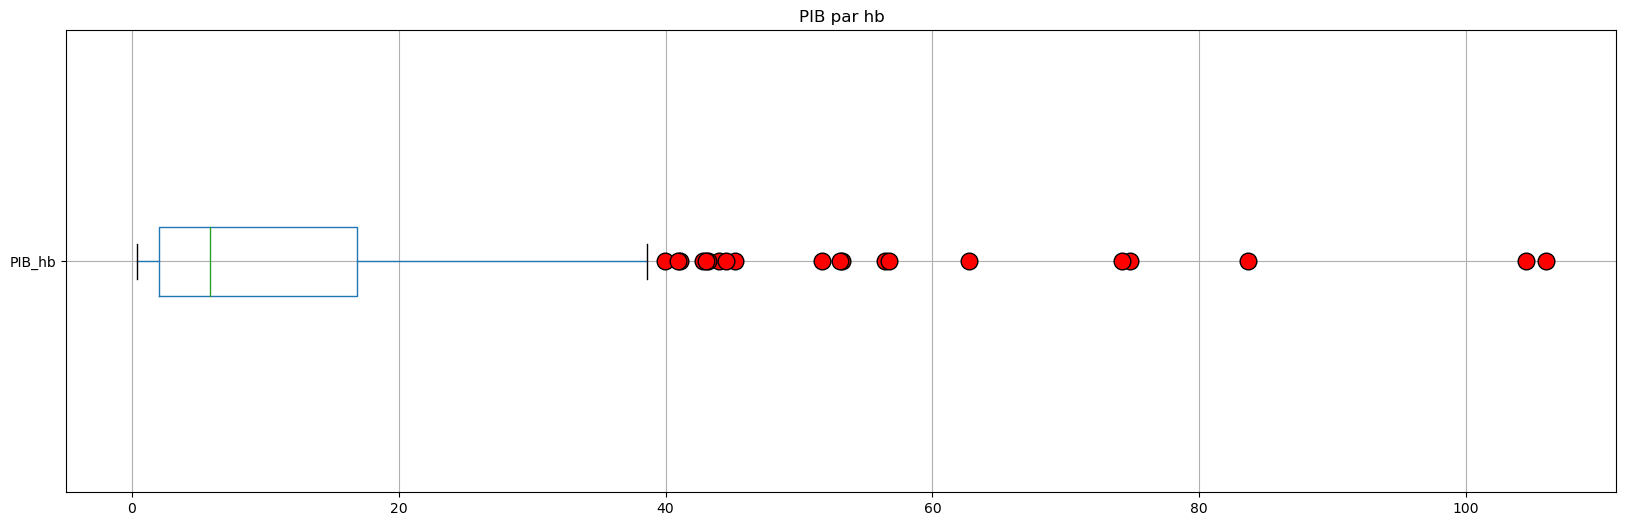

In [76]:
plt.figure(figsize=(20,6))
#définit le style des outliers (flier pour matplotlib)
flierprops = dict(marker='o', markerfacecolor='red', markersize=12,
                  linestyle='none')
df_temp.boxplot(column = 'PIB_hb', vert = False, flierprops=flierprops)
plt.title('PIB par hb')
plt.show()

==> Remarques: la plage des outliers est très large. Nous devrons créer une valeur normalisée pour réduire la distribution.

**Normalisation** des données.

Avant normalisation, valeur à zéro interdite, or la variable 'Importation volailles' a une valeur min à zéro. Quels sont les pays concernés?

In [77]:
df_temp.loc[df_temp['Importation volailles (Milliers de t)']==0]

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,distance dps France(en km),Sous Continent,Code ISO3,Continent,Country Name,Country Code,PIB_hb,distance_moy,Imp_vol_moy,Dispo_prot_moy
11,16,Bangladesh,4724.0,60.22,0.0,161376.708,5.34,-0.92,0.29,7916.790,Asie méridionale,BGD,Asie,Bangladesh,BGD,1.248453,7156.885143,6.125000,69.166250
16,23,Belize,58.0,67.11,0.0,383.071,9.75,0.51,0.47,8664.439,Amérique centrale,BLZ,Amériques,Belize,BLZ,6.124456,8882.826571,146.500000,74.443750
21,32,Cameroun,788.0,69.49,0.0,25216.267,12.45,-1.53,-0.54,5085.718,Afrique centrale,CMR,Afrique,Cameroun,CMR,1.382510,5459.527000,66.285714,61.061429
25,38,Sri Lanka,1017.0,64.27,0.0,21228.763,2.66,-0.05,-0.14,8526.015,Asie méridionale,LKA,Asie,Sri Lanka,LKA,4.072166,7156.885143,6.125000,69.166250
40,58,Équateur,1094.0,65.77,0.0,17084.358,8.06,-0.36,-0.22,9642.005,Amérique du Sud,ECU,Amériques,Équateur,ECU,6.124492,9642.005000,29.333333,77.258333
60,91,Guyana,64.0,87.58,0.0,779.006,2.53,-0.15,-0.01,7320.075,Amérique du Sud,GUY,Amériques,Guyana,GUY,5.576847,9642.005000,29.333333,77.258333
67,100,Inde,16828.0,65.70,0.0,1352642.280,5.31,-0.86,0.09,6594.230,Asie méridionale,IND,Asie,Inde,IND,1.605605,7156.885143,6.125000,69.166250
72,105,Israël,1143.0,122.62,0.0,8381.516,7.72,-0.83,0.26,3281.899,Asie occidentale,ISR,Asie,Israël,ISR,38.029036,3815.390692,155.214286,85.746429
80,114,Kenya,1136.0,60.87,0.0,51392.565,11.43,-1.00,0.24,6491.402,Afrique orientale,KEN,Afrique,Kenya,KEN,1.464554,7471.611400,4.166667,60.415000
91,129,Madagascar,520.0,42.94,0.0,26262.313,12.57,-0.46,-0.03,8763.332,Afrique orientale,MDG,Afrique,Madagascar,MDG,0.467235,7471.611400,4.166667,60.415000


**==> Remarques:** bcp de pays concernés, on va remplacer les zéros par la moyenne du sous-groupe.

In [78]:
df_temp.loc[df_temp['Importation volailles (Milliers de t)']==0, 'Importation volailles (Milliers de t)']=df_temp['Imp_vol_moy']

In [79]:
#normalisation
df_temp['Index_prot_animales']=np.log(df_temp['Dispo int prot animales (Milliers de t)'])
df_temp['Index_imp_volailles']=np.log(df_temp['Importation volailles (Milliers de t)'])
df_temp['Index_pop'] = np.log(df_temp['Population 2018 (Milliers d\'hab)'])
df_temp['Index_pib'] = np.log(df_temp['PIB_hb'])

In [80]:
#vérification du df
df_temp.describe(include='all').round(2)

,Code zone,Zone,Dispo int prot animales (Milliers de t),Dispo protéines (en g/personne/jour),Importation volailles (Milliers de t),Population 2018 (Milliers d'hab),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,distance dps France(en km),...,Country Name,Country Code,PIB_hb,distance_moy,Imp_vol_moy,Dispo_prot_moy,Index_prot_animales,Index_imp_volailles,Index_pop,Index_pib
count,171.0,171,171.00,171.00,171.00,171.00,171.00,171.00,171.00,171.00,...,171,171,171.00,171.00,171.00,171.00,171.00,171.00,171.00,171.00
unique,171.0,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1.0,Arménie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Arménie,ARM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,3005.91,81.59,93.50,43101.67,6.13,-0.06,-0.02,6031.74,...,NaN,NaN,13.86,6031.74,86.98,81.19,6.19,3.16,8.94,1.76
std,NaN,NaN,13126.01,20.15,185.10,154742.52,5.35,0.89,0.29,3935.06,...,NaN,NaN,19.43,3869.76,89.54,15.60,1.86,1.75,1.99,1.39
min,NaN,NaN,4.00,39.91,1.00,52.44,-7.41,-2.73,-0.96,278.19,...,NaN,NaN,0.38,484.39,1.00,60.42,1.39,0.00,3.96,-0.97
25%,NaN,NaN,148.00,64.77,6.12,2364.20,2.41,-0.61,-0.15,2284.59,...,NaN,NaN,2.00,2313.36,28.50,68.59,5.00,1.81,7.77,0.69
50%,NaN,NaN,511.00,81.63,23.00,9587.52,5.67,0.00,-0.01,5620.00,...,NaN,NaN,5.84,5459.53,52.00,77.26,6.24,3.14,9.17,1.76
75%,NaN,NaN,1402.00,97.12,86.50,31168.91,10.20,0.66,0.12,8595.23,...,NaN,NaN,16.85,8571.69,122.30,90.80,7.25,4.46,10.35,2.82


==> On regarde si **corrélation** entre les variables

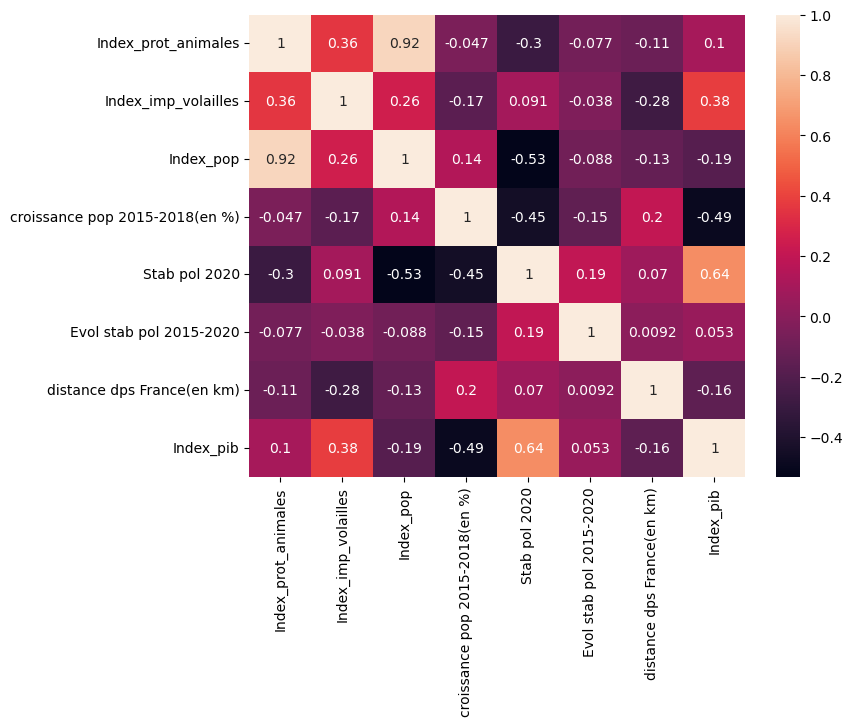

In [81]:
# création df avec variables quanti que l'on veut analyser ensuite:
df_corr = df_temp[['Index_prot_animales','Index_imp_volailles',
                   'Index_pop','croissance pop 2015-2018(en %)',
                  'Stab pol 2020','Evol stab pol 2015-2020',
                  'distance dps France(en km)','Index_pib']]

#matrice de corrélation en heatmap
corr_df = df_corr.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

**==> Remarques:** L'index de prot animales et l'index de population sont très corrélés. On ne conservera que l'index pop pour la suite de l'analyse.

In [82]:
#export du df dans un fichier csv
df_temp.to_csv('df_temp.csv', index=False)

## Chapitre 3: Création du df de travail: Nettoyage et préparation <a class="anchor" id="chapter3"></a>

In [83]:
#Copie du df complet pour pouvoir travailler dessus
df=df_temp.copy()

In [84]:
# on stocke le nom des zones dans une variable names
names = df.Zone.values

In [85]:
#on 'crée' df_quanti, X et features, en ne conservant que les variables quanti
df_quanti = df[['Zone','Dispo protéines (en g/personne/jour)',
                'croissance pop 2015-2018(en %)', 'Stab pol 2020',
               'Evol stab pol 2015-2020','distance dps France(en km)',
               'Index_imp_volailles','Index_pop','Index_pib']]
features = df_quanti.drop(columns=['Zone']).columns
X = df_quanti.drop(columns=['Zone']).values

In [86]:
#scaling - instancie et entraine
std_scale=preprocessing.StandardScaler().fit(X)
#scaling - transforme
X_scaled = std_scale.transform(X)

In [87]:
#on vérifie que la moyenne est à 0 et l'écart-type à 1
pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]

,0,1,2,3,4,5,6,7
mean,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**==> Remarques:** Le df est ok. On va lancer l'ACP.

## Chapitre 4: Analyse exploratoire des données - ACP <a class="anchor" id="chapter4"></a>

### 4.1 Eboulis des valeurs propres <a class="anchor" id="section_4_1"></a>

Pour choisir le nombre de composantes, nous allons visualiser le diagramme éboulis des valeurs propres:

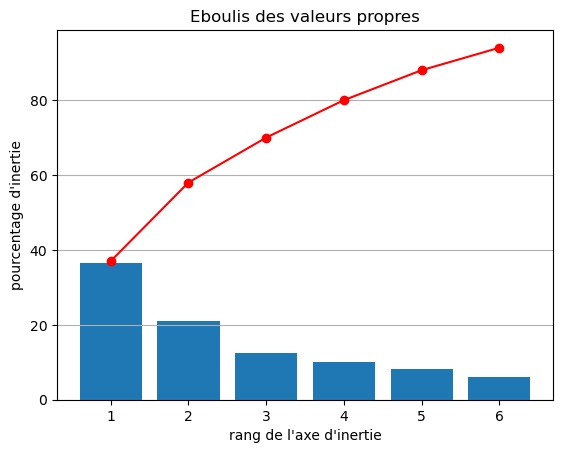

In [88]:
# construction du graphe pour visualiser la variance totale
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(X_scaled)
#eboulis valeur propre
pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.grid(axis='y')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

**==> Remarques:** Avec 4 composantes nous atteignons 80% de la variance totale.

In [91]:
# ACP à 4 composantes
n_components = 4
x_list = range(1, n_components+1)
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=4)

### 4.2 Les composantes <a class="anchor" id="section_4_2"></a>

In [92]:
#affichage des composantes et leur contribution
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features #pour nom des colonnes = variables
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,Dispo protéines (en g/personne/jour),croissance pop 2015-2018(en %),Stab pol 2020,Evol stab pol 2015-2020,distance dps France(en km),Index_imp_volailles,Index_pop,Index_pib
F1,0.48,-0.43,0.44,0.08,-0.18,0.24,-0.17,0.52
F2,-0.20,-0.02,0.39,0.23,0.44,-0.46,-0.59,-0.02
F3,0.13,0.16,0.07,-0.92,0.21,-0.04,-0.18,0.14
F4,-0.09,0.19,0.14,0.14,0.72,0.52,0.30,0.21


<Axes: >

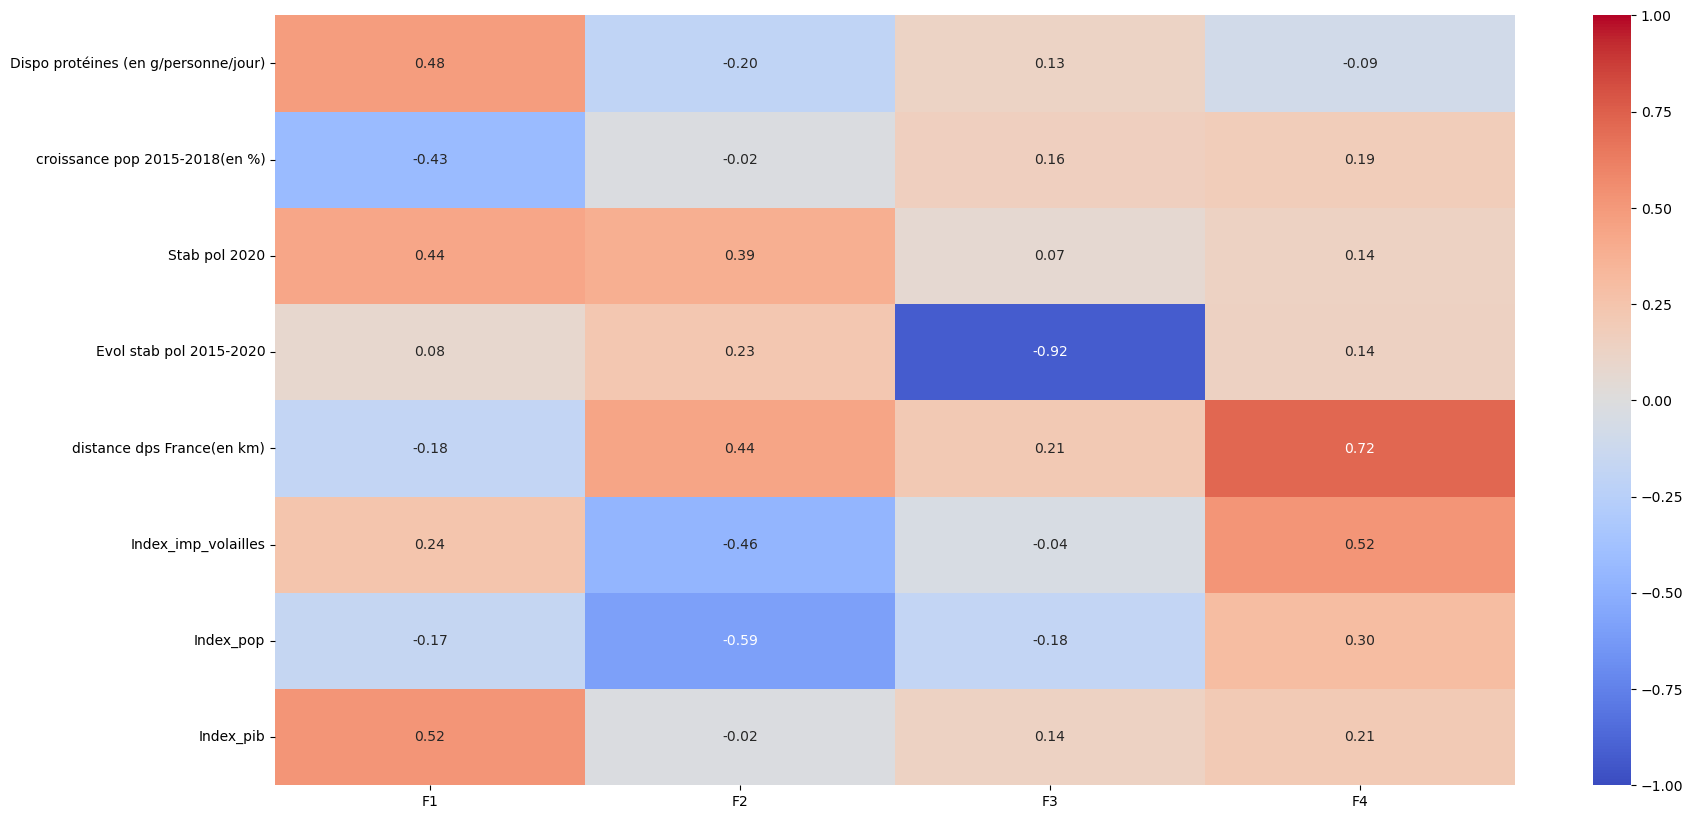

In [93]:
#affichage en couleur
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

**==> Remarques:**

- Les principales contributions à F1 sont (dans l'ordre décroissant):  Index_PIB, Dispo protéines, Stabilité politique, et croissance pop en négatif
- Les principales contributions à F2 sont (dans l'ordre décroissant): Distance dps la FR et, Index pop et Index importation volailles tous les 2 en négatif.
- La principale contribution à F3 est : Evolution de la stabilité politique en négatif
- Les principales contributions à F4 sont (dans l'ordre décroissant): Distance depuis la FR, et l'index d'importation de volailles.

### 4.3 Les cercles de corrélation <a class="anchor" id="section_4_2"></a>

Représentons les variables sur les cercles de corrélation.

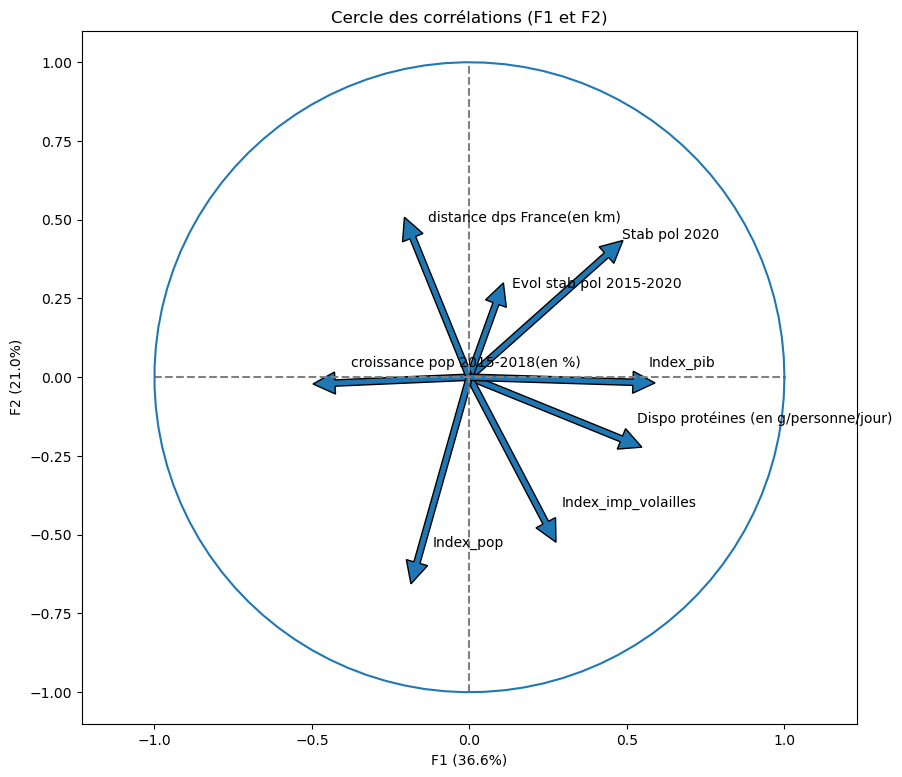

In [94]:
#Projection sur F1 et F2
x_y=(0,1)
correlation_graph(pca,x_y,features)

**==> Remarques:**

1ère composante:
- contribution positive: Dispo protéines et Index_PIB, stabilité politique
- contribution négative: croissance population

2ème composante:
- contribution positive: distance dps la Fr, stabilité politique
- contribution négative: Index de population, index d'importation de volailles

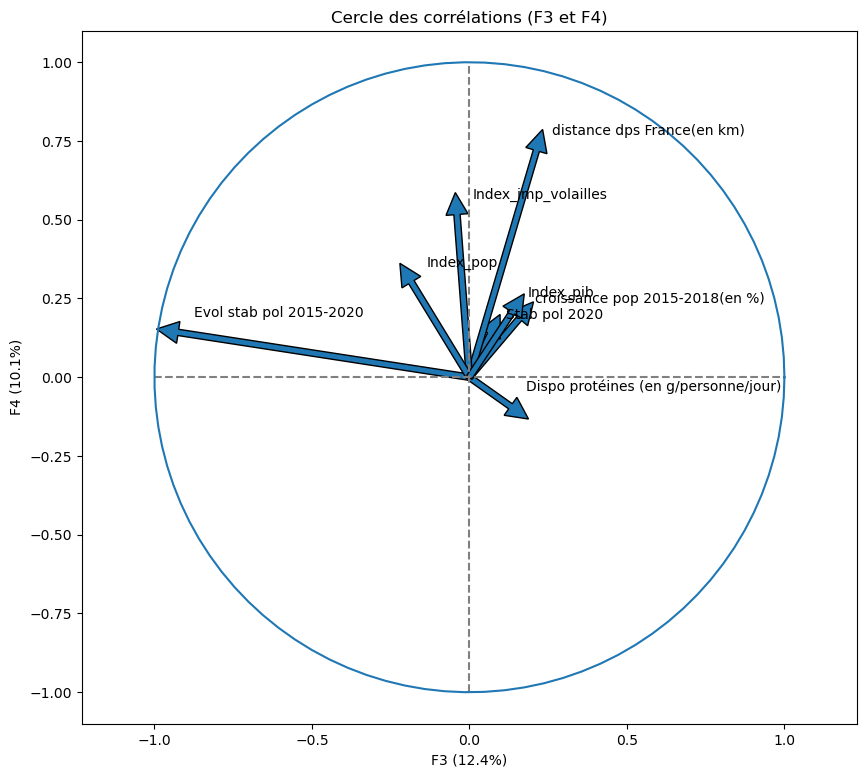

In [95]:
#Projection sur F3 et F4
x_y=(2,3)
correlation_graph(pca,x_y,features)

**==> Remarques:**

3ème composante:
- contribution positive: pas de variable qui sort du lot. 
- contribution négative: evolution de la stabilité politique

4ème composante:
- contribution positive: Distance dps la FR, Index d'importation de volailles
- contribution négative: aucune

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_14004\3725752176.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette="deep")


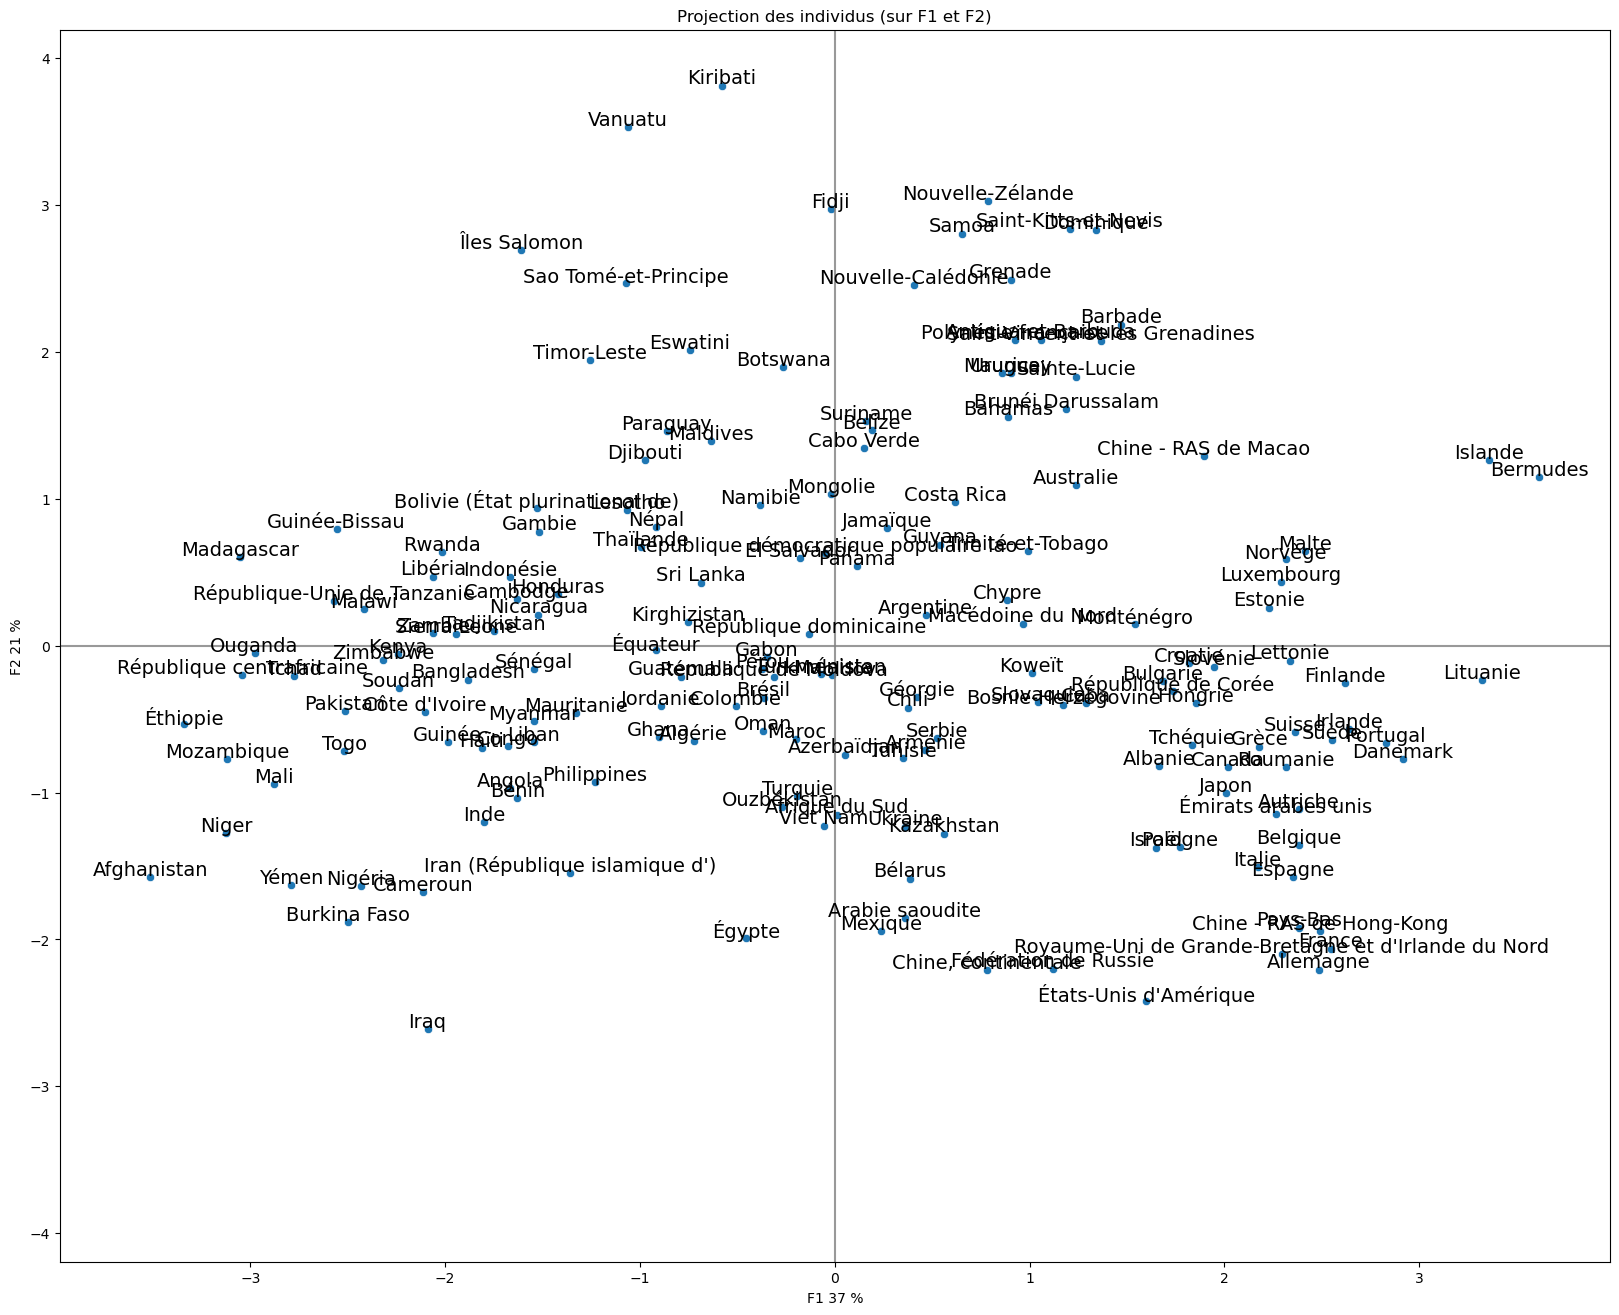

In [96]:
#Projection des individus sur F1 et F2
X_projected = pca.transform(X_scaled)
x_y = [0,1]
display_factorial_planes(X_projected, x_y, pca, figsize=(20,16), labels = names, marker="o")

**==> Remarques:** D'après l'analyse du cercle de corrélation, on cherche des pays situés dans le quart droit-bas

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_14004\3725752176.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette="deep")


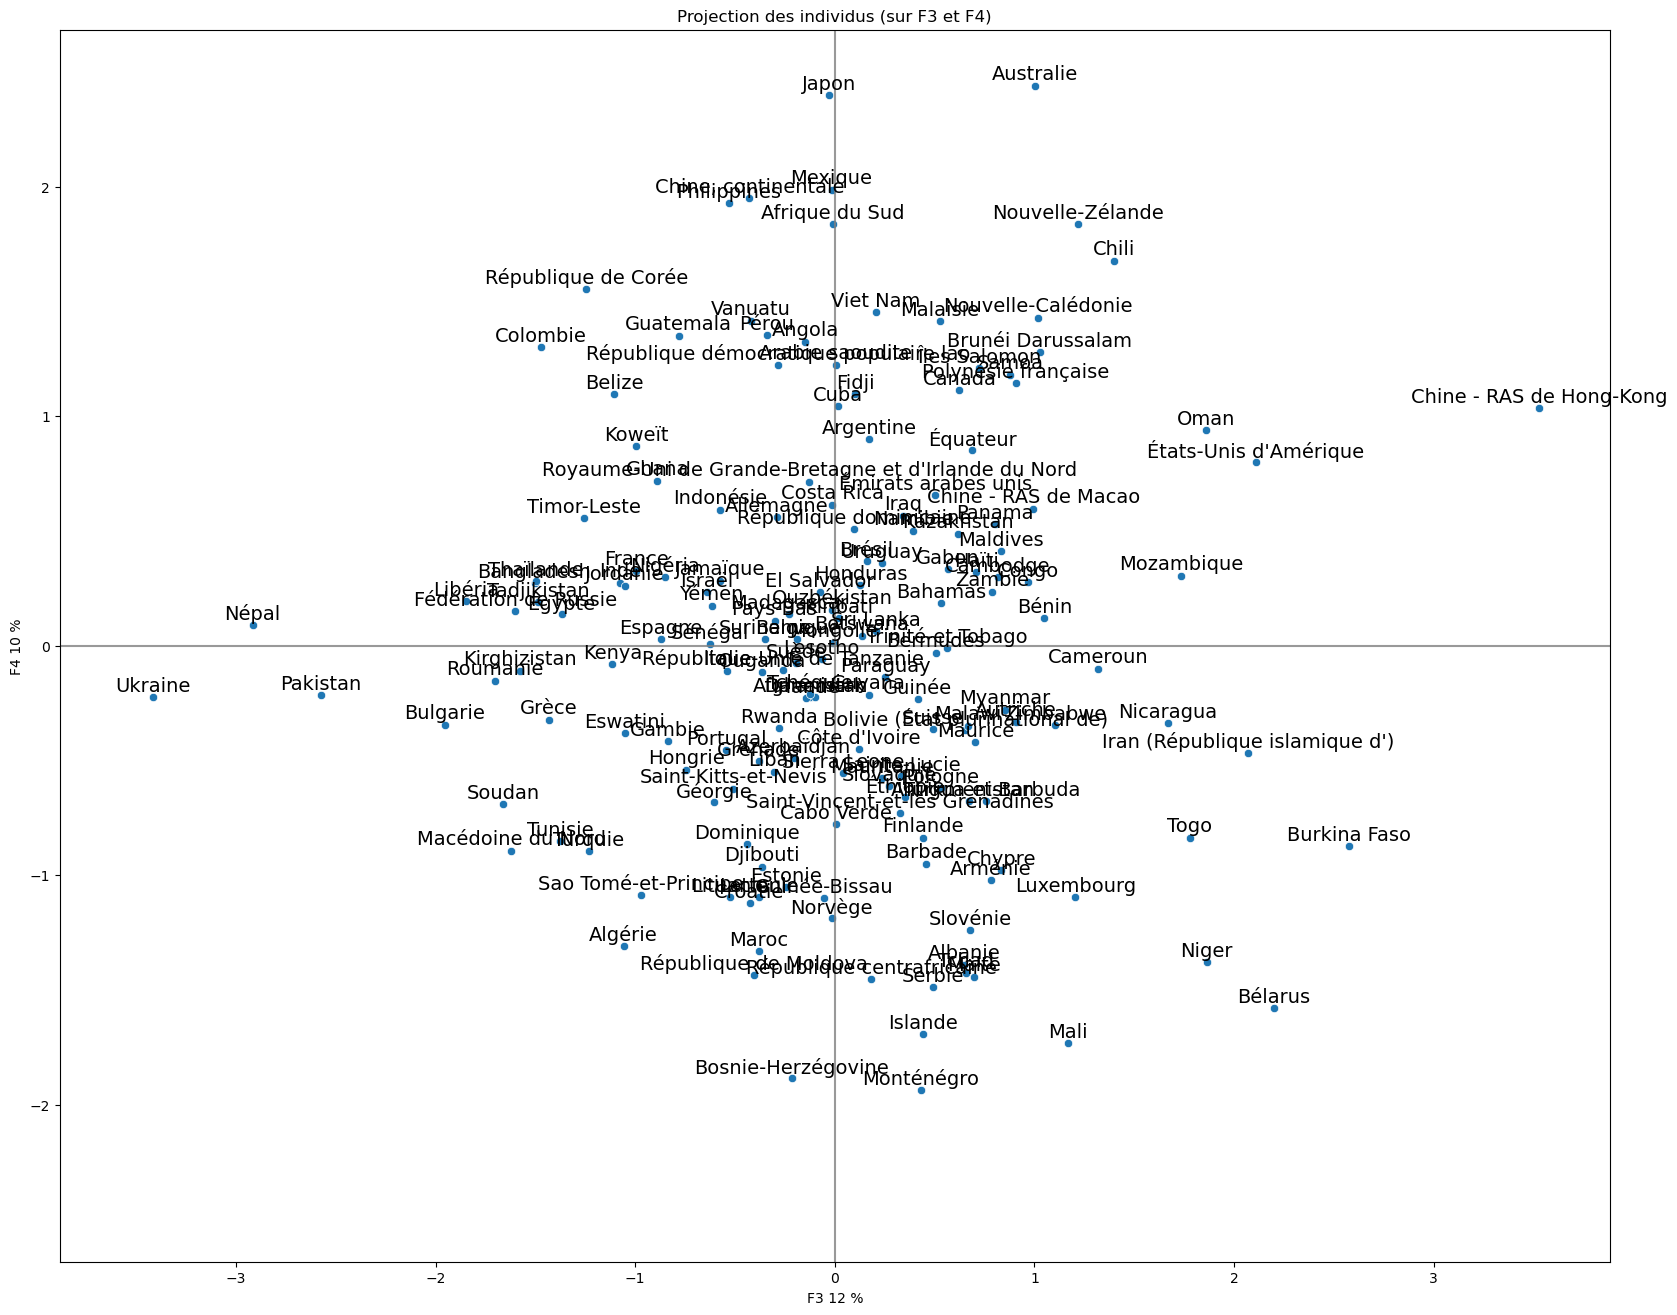

In [97]:
#Projection des individus sur F3 et F4
X_projected = pca.transform(X_scaled)
x_y = [2,3]
display_factorial_planes(X_projected, x_y, pca, figsize=(20,16), labels = names, marker="o")

**==> Remarques:** D'après l'analyse du cercle de corrélation, on cherche des pays situés dans la moitié basse.